<Figure size 6000x3000 with 0 Axes>

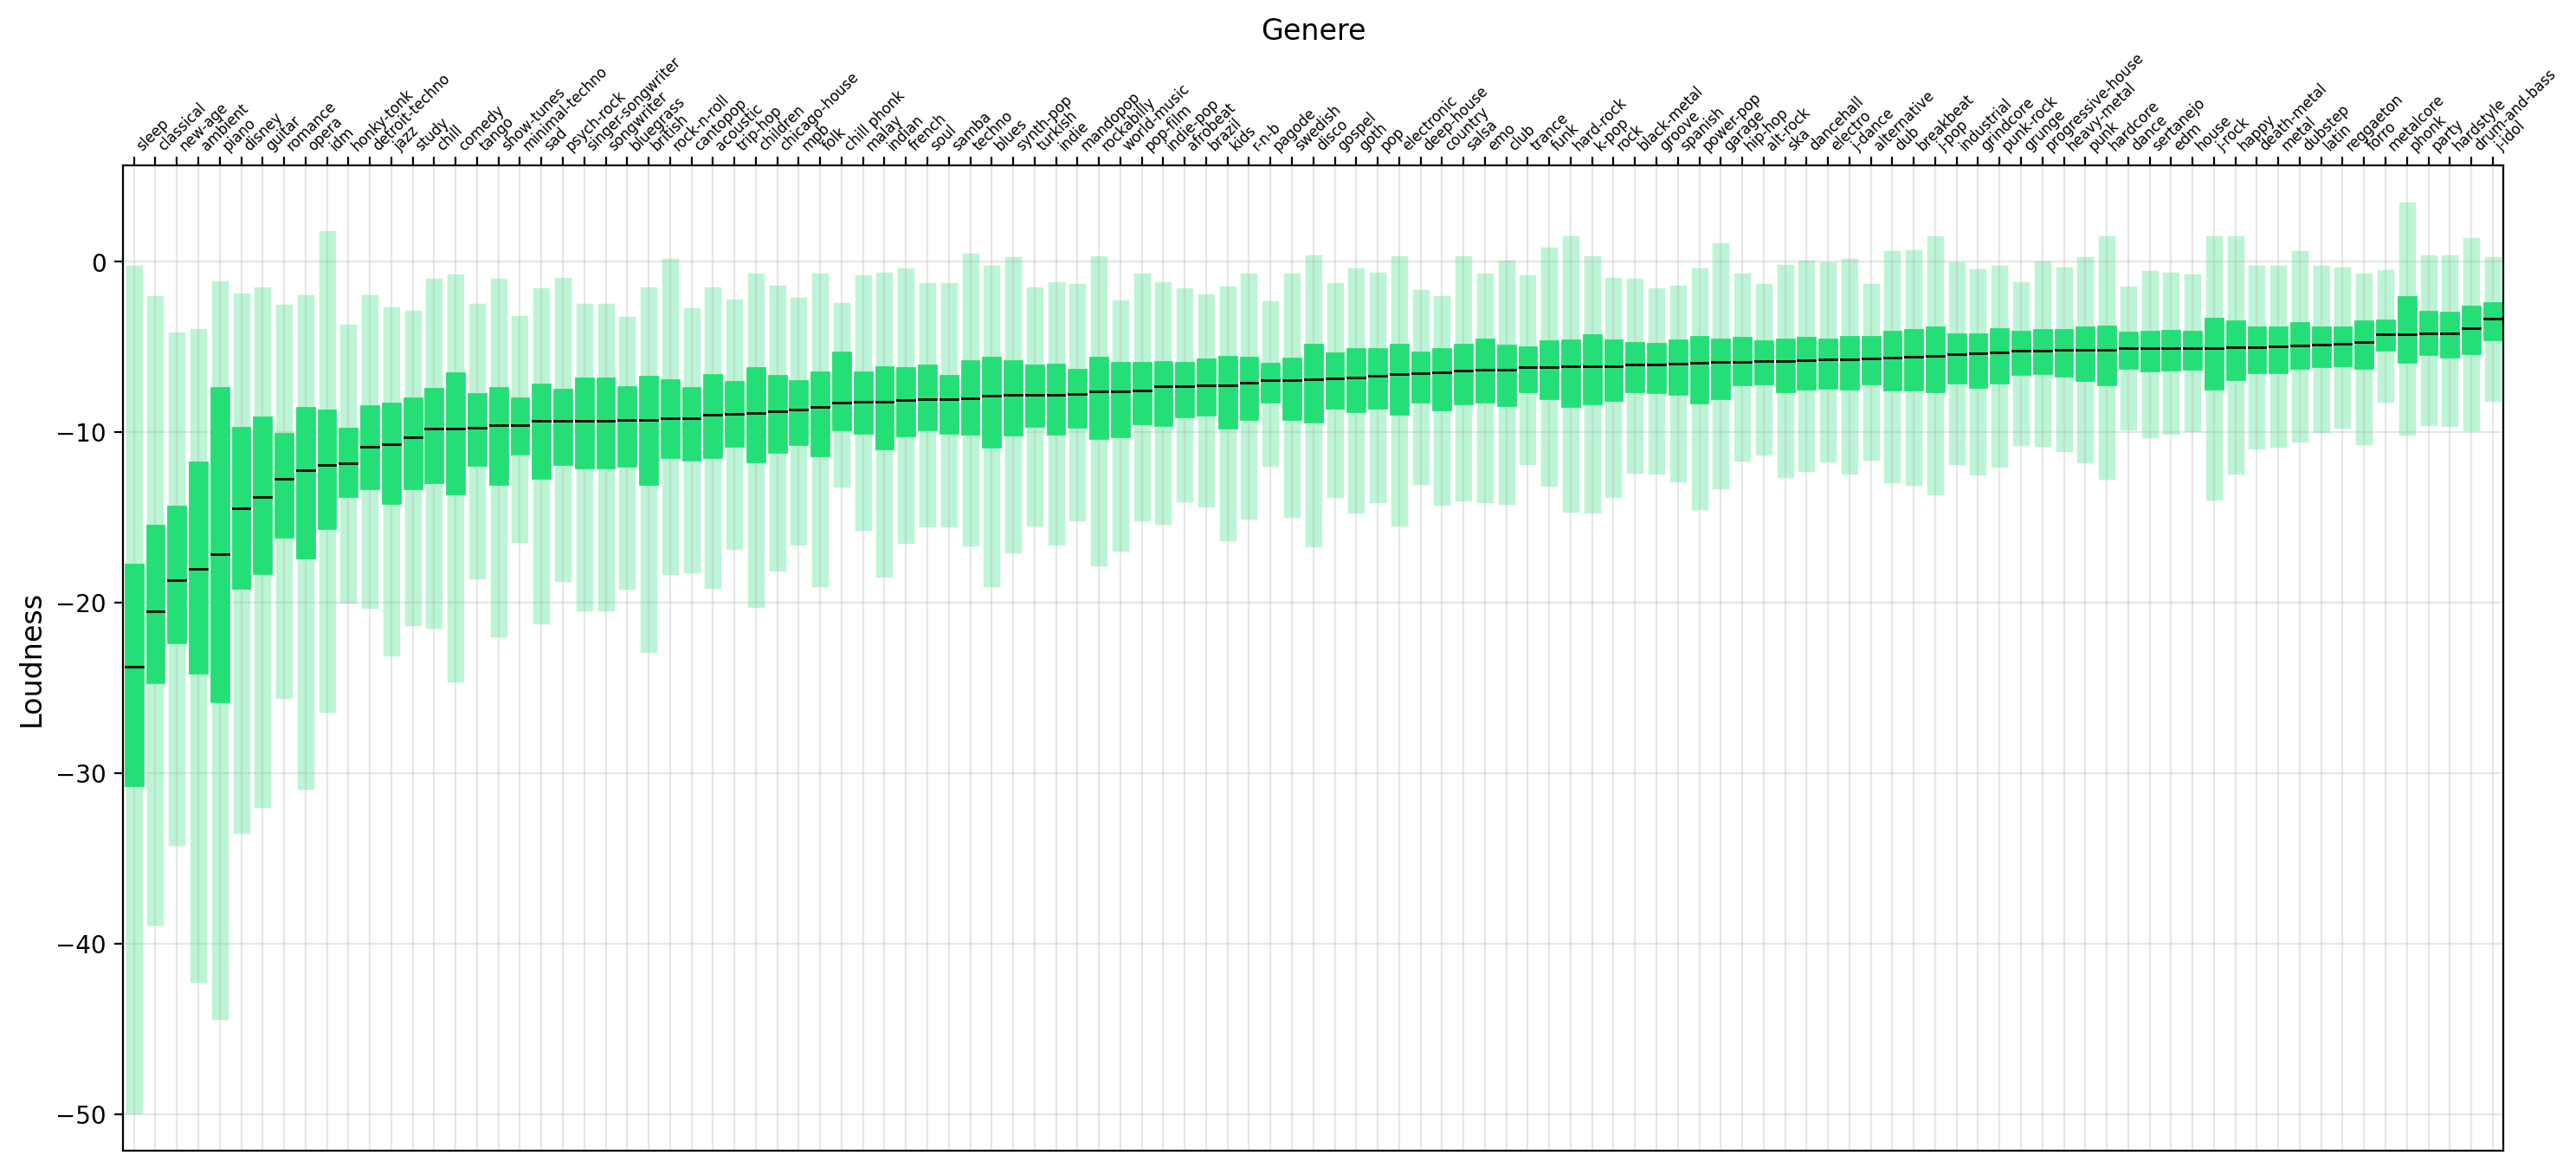

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('spotify_dataset.csv')
genre = 'track_genre'
loudness = 'loudness'
df.drop_duplicates()
df = df.dropna()

df = df[~df[genre].str.contains('german|iranian|anime', regex=True)] # rimuovo categorie ampissime
df.loc[df[genre].str.contains('latin', regex=True), genre] = 'latin'
df.loc[df[genre].str.contains('reggae', regex=True), genre] = 'reggaeton' #non si sa com'è successo questo


df2 = pd.read_csv('spotify_song_attributes.csv')
df2.rename(columns={'genre' : genre, 'id' : 'track_id', 'trackName' : 'track_name', 'artistName' : 'artists'}, inplace=True)
df2 = df2[df2[genre].str.contains('phonk', case=False, na=False)]
df2.loc[df2[genre].str.contains('aggressive|drift|gym', regex=True), genre] = 'phonk'

df2 = df2.dropna()
df2.drop_duplicates()

# prendiamo solo generi con almeno 200 canzoni
min_entries = 200
genre_counts = df[genre].value_counts()
valid_genres = genre_counts[genre_counts >= min_entries].index
df = df[df[genre].isin(valid_genres)]

df = pd.concat([df, df2])

# ordiniamo per mediana
avg_loudness = df.groupby(genre)[loudness].median().sort_values()
sorted_genres = avg_loudness.index
df = df.loc[df[genre].isin(sorted_genres), :]
df[genre] = pd.Categorical(df[genre], categories=sorted_genres, ordered=True)
df = df.sort_values(genre)

# definiamo un bel colore per i grafici, preso dallo sfondo della diapositiva
spotifygreen = "#24df76"

# boxplot
plt.figure(figsize=(30, 15))
plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["figure.dpi"] = 200

boxprops        = dict(facecolor=spotifygreen, linewidth = 1, color = spotifygreen)
whiskerprops    = dict(color=spotifygreen, linewidth=7, zorder=-1, alpha = 0.3)
capprops        = dict(color=spotifygreen, linewidth=1)
medianprops     = dict(color="black")

ax = df.boxplot(column=loudness, by=genre, widths=0.8, showcaps=False, capwidths=0.8, grid=False, patch_artist=True, notch=False, vert=True, showfliers=False, showmeans=False, meanline=False,
                whiskerprops=whiskerprops,
                boxprops=boxprops,
                capprops=capprops,
                medianprops=medianprops)

ax.grid(True, alpha=0.3)

plt.ylabel("Loudness", fontsize=12)
plt.xlabel("Genere", fontsize=12)
plt.title('', fontsize=0.1)
plt.suptitle('')

# spostiamo in alto i label ruotandoli per leggibilità
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.xticks(rotation=45, ha='left', fontsize=6)
labels = plt.gca().get_xticklabels()
for label in labels:
    label.set_y(label.get_position()[1] - 0.005)
plt.gca().set_xticklabels(labels)

plt.tight_layout()
plt.show()



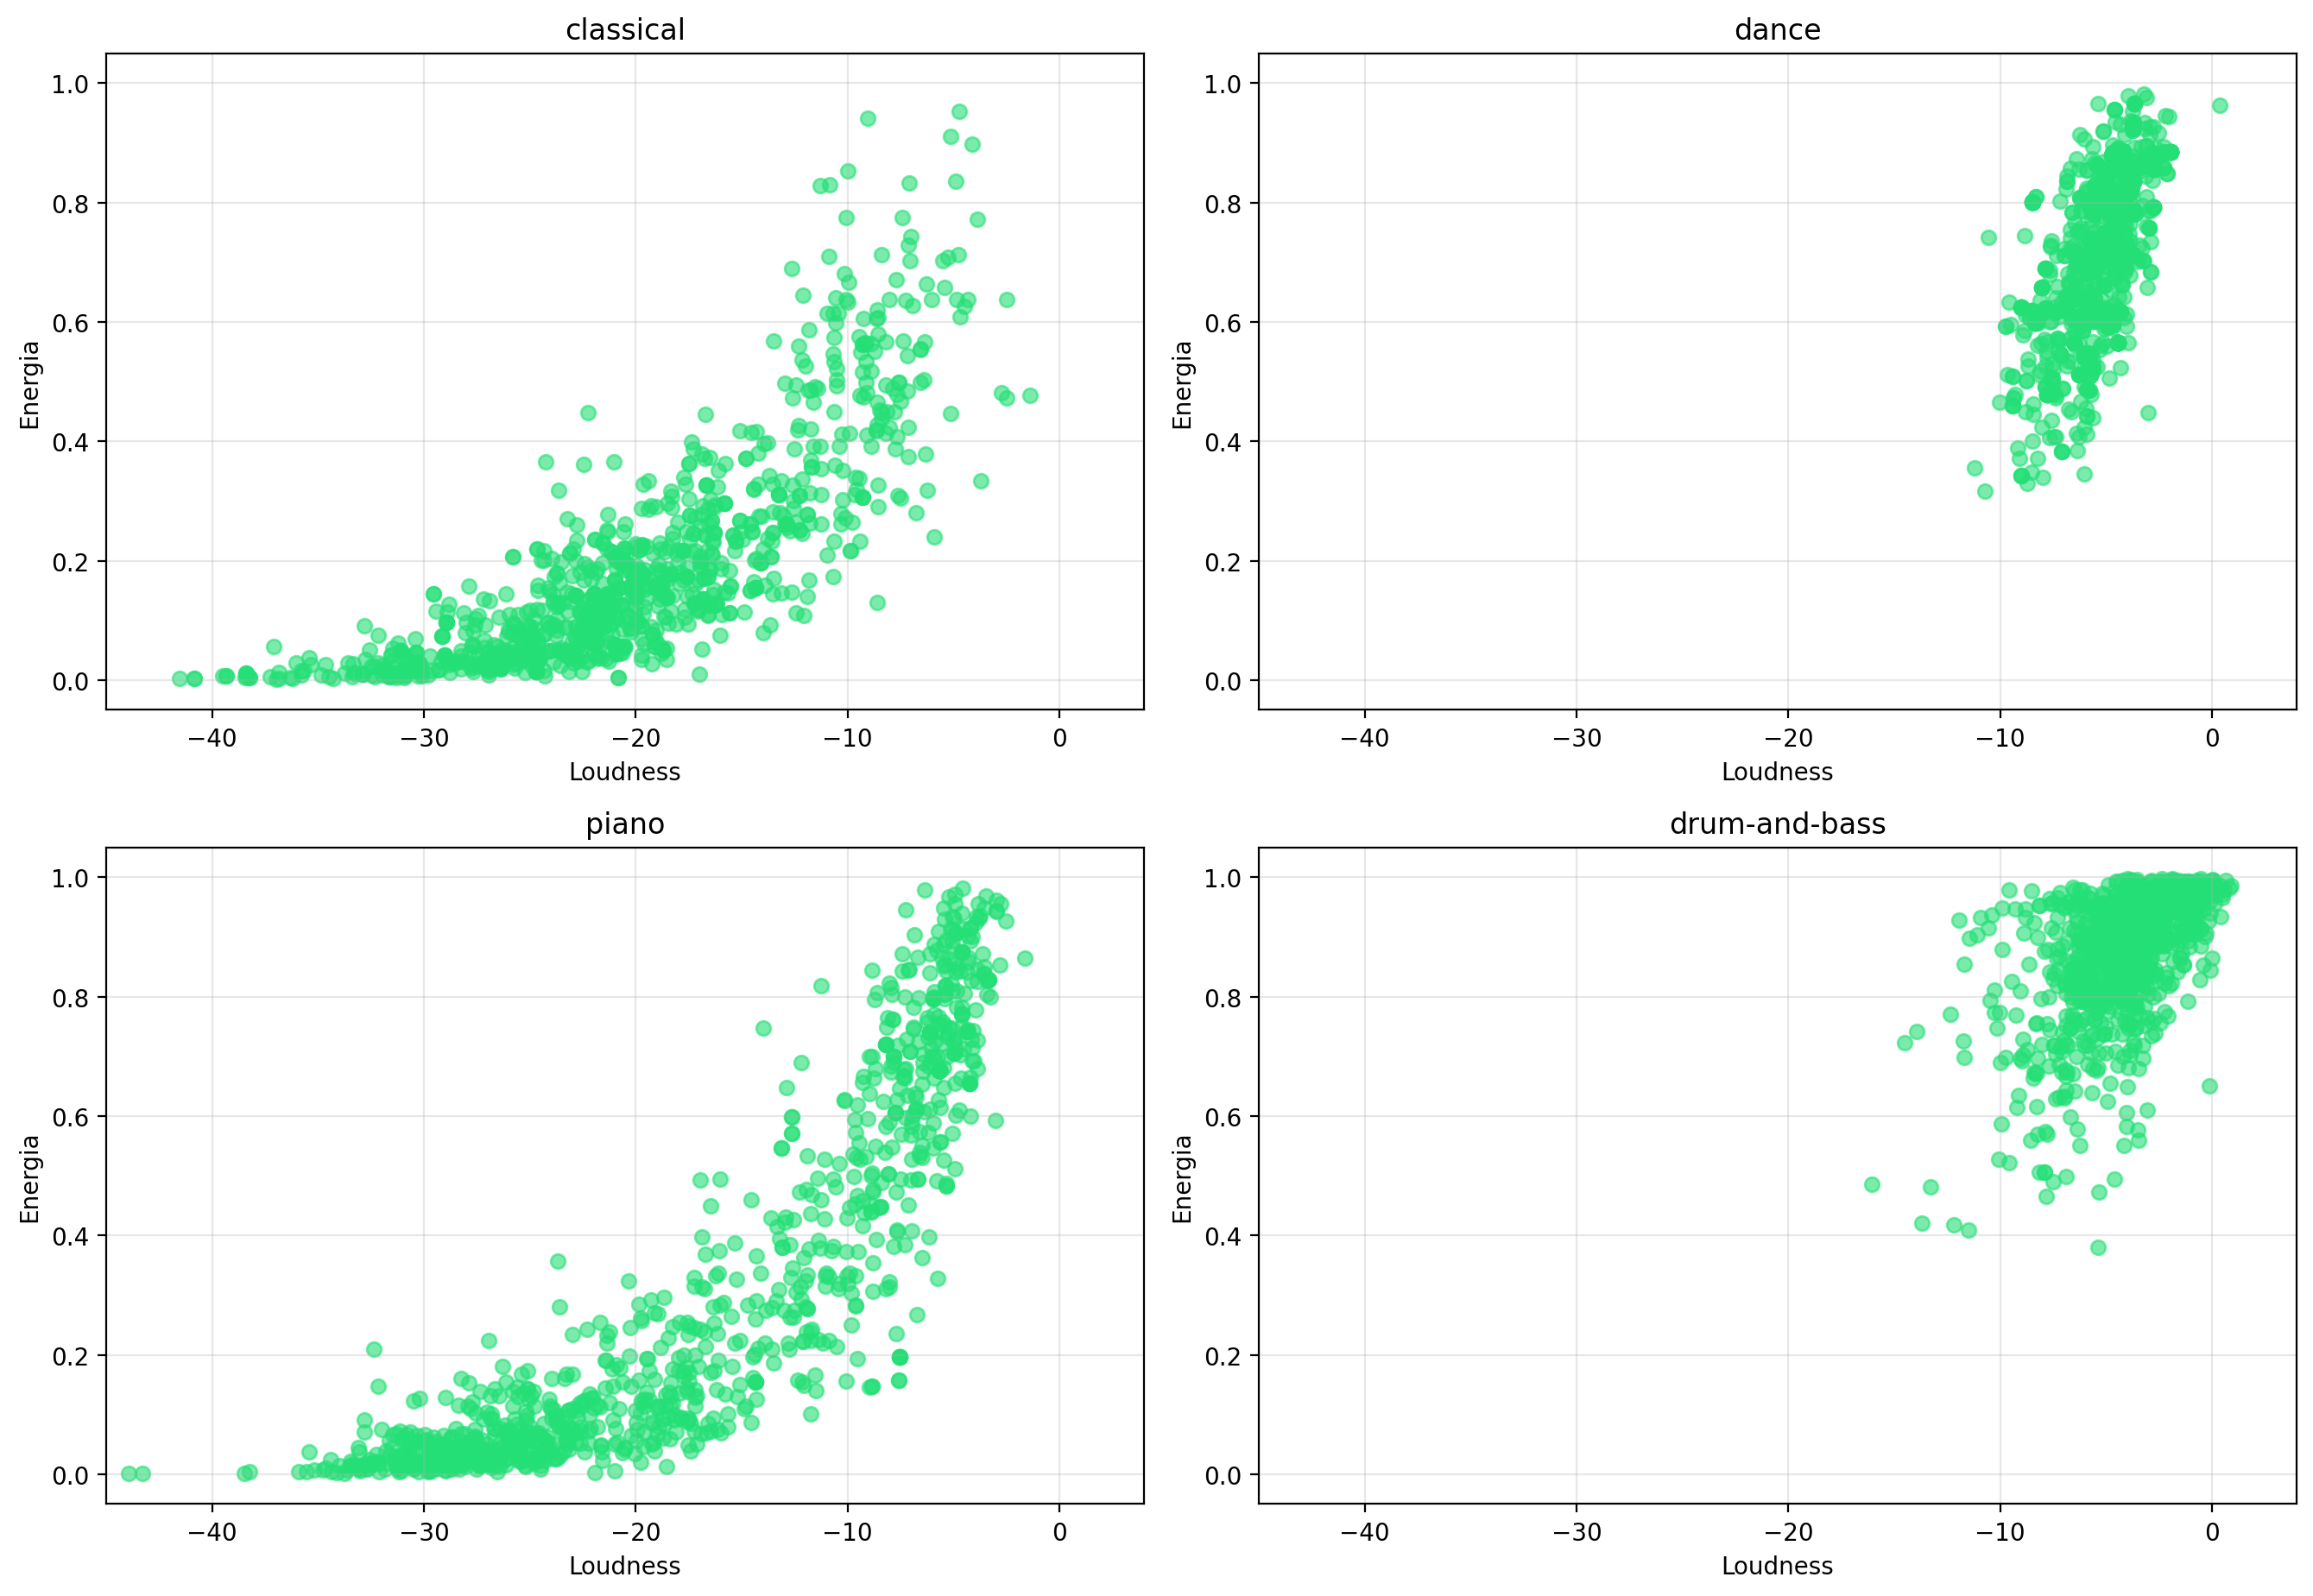

In [4]:
energy = 'energy'

# fissiamo un range uguale per tutti così si vede la differenza (perché non è così in automatico??)
x_limits = (-45, 4)
y_limits = (-0.05,1.05)

# Selezioniamo tot generi
selected_genres = ['classical', 'dance', 'piano', 'drum-and-bass']
df_filtered = df[df[genre].isin(selected_genres)]

# scatterplot con 4 subplot
fig, axs = plt.subplots(2, 2, figsize=(13.5, 10))
fig.suptitle('', fontsize=0.1)


for i, genre_name in enumerate(selected_genres):
    ax = axs[i // 2, i % 2]
    genre_data = df_filtered[df_filtered[genre] == genre_name]
    ax.scatter(genre_data[loudness], genre_data[energy], color=spotifygreen, alpha=0.6)
    
    ax.set_title(genre_name, fontsize=12)
    ax.set_xlabel("Loudness", fontsize=10)
    ax.set_ylabel("Energia", fontsize=10)

    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


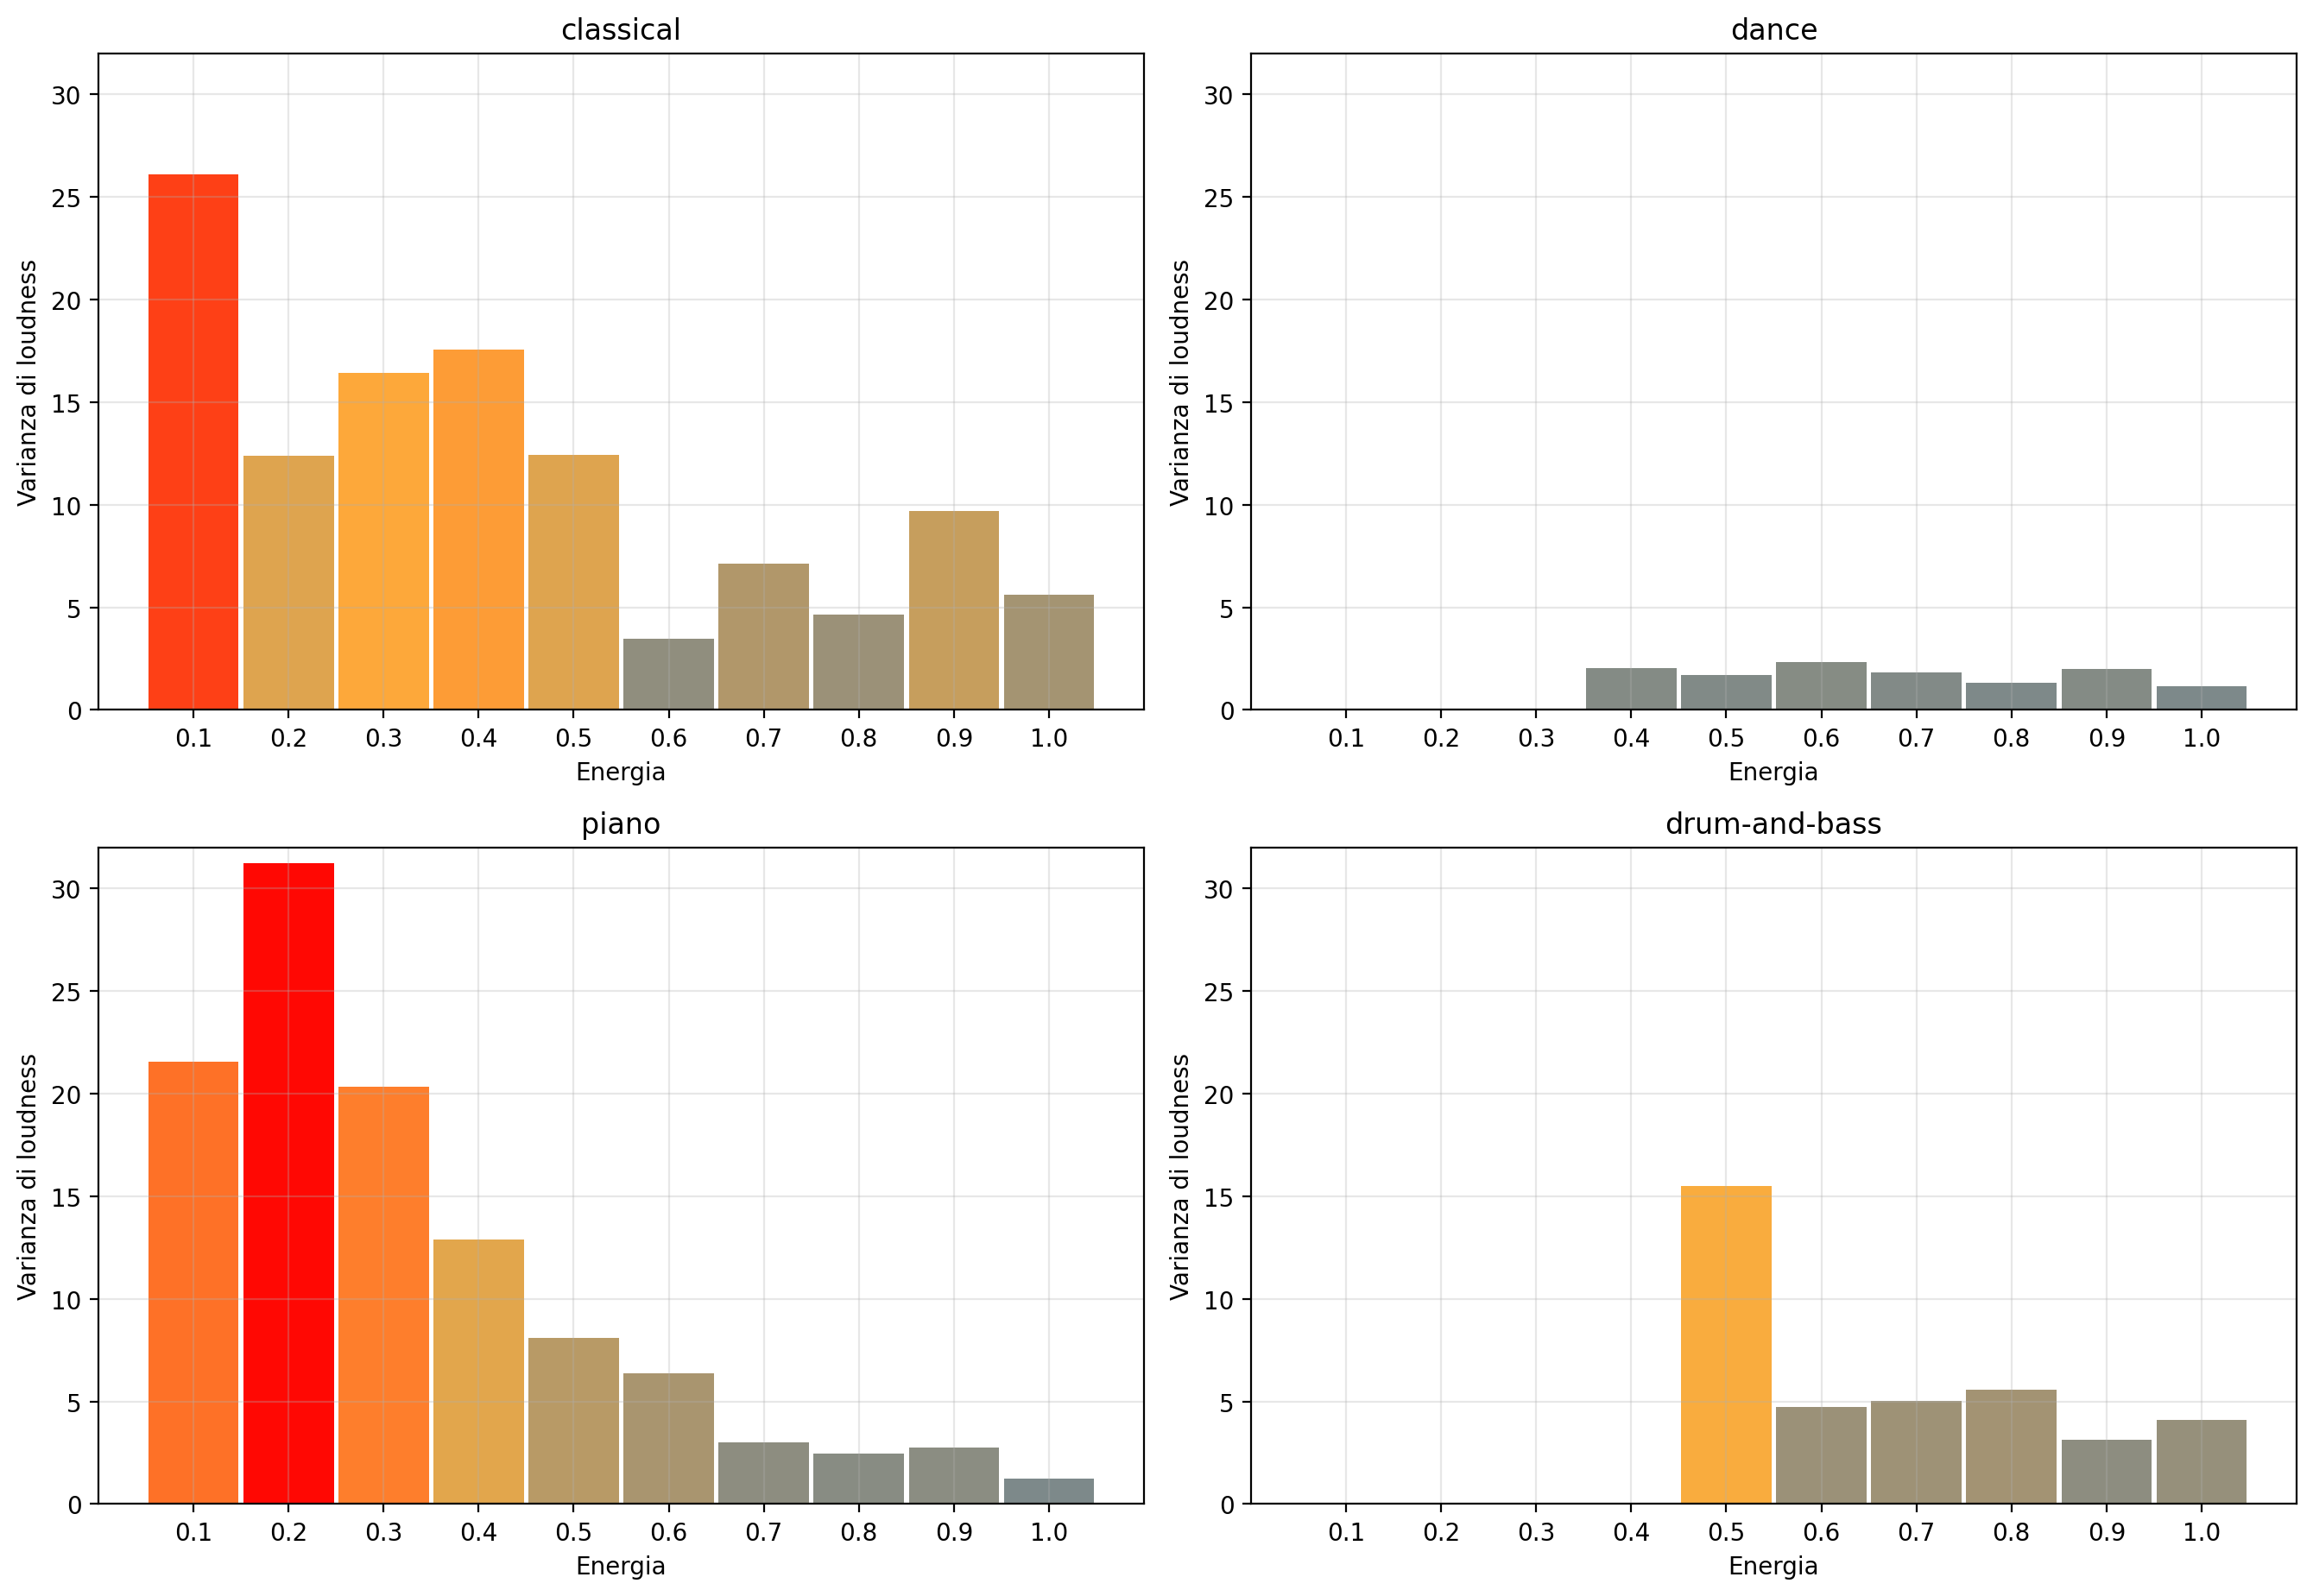

In [5]:
# cerchiamo la varianza per intervallo di intensità per ciascun genere.

import matplotlib.colors as pltc

x_limits = (-1, 10)
y_limits = (0,32)

# definiamo 10 intervalli
energy_bins = np.linspace(0, 1, 11)
energy_labels = [f"{round(energy_bins[i+1], 1)}" for i in range(len(energy_bins)-1)]

custom_colors = ['#738690', '#fdad3c', 'red']
cmap = pltc.LinearSegmentedColormap.from_list('custom_cmap', custom_colors)

norm = pltc.Normalize(y_limits[0], y_limits[1])

# 4 subplot
fig, axs = plt.subplots(2, 2, figsize=(13.5, 10))
fig.suptitle('', fontsize=0)

for i, genre_name in enumerate(selected_genres):
    ax = axs[i // 2, i % 2]
    
    genre_data = df_filtered.loc[df_filtered[genre] == genre_name].copy()
    genre_data.loc[:, 'energy_range'] = pd.cut(genre_data['energy'], bins=energy_bins, labels=energy_labels, include_lowest=True)

    loudness_variance = genre_data.groupby('energy_range')['loudness'].var()

    ax.bar(loudness_variance.index, loudness_variance.values, color=cmap(norm(loudness_variance.values)), width=0.95)

    ax.set_title(genre_name, fontsize=12)
    ax.set_xlabel("Energia", fontsize=10)
    ax.set_ylabel("Varianza di loudness", fontsize=10)

    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



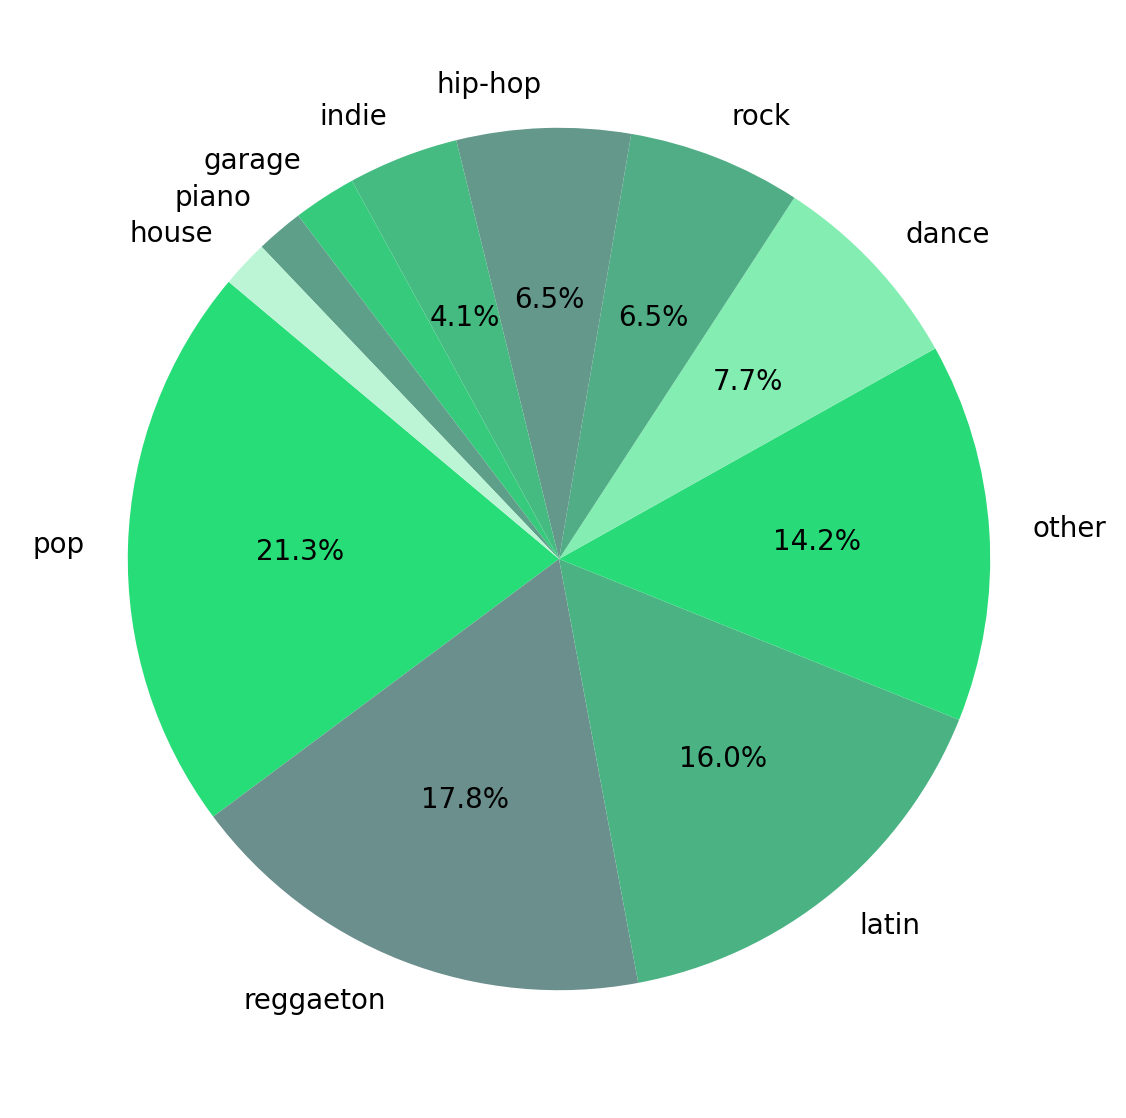

In [6]:
# Quali sono i generi delle canzoni più popolari?

popularity = 'popularity'

custom_colors = ['#738690', spotifygreen, 'white']
cmap = pltc.LinearSegmentedColormap.from_list('custom_cmap', custom_colors)

# scegliamo solo tracce con popolarità 88 o superiore, contiamo e raggruppiamo tra loro quelle con troppe poche tracce in un sottogenere "other"
df_filtered = df[df[popularity] >= 88].copy()
genre_counts = df_filtered[genre].value_counts()
genres_to_group = genre_counts[genre_counts <= 2].index
df_filtered[genre] = df_filtered[genre].replace(genres_to_group, 'other')

# ricontiamo per la nuova categoria other
final_genre_counts = df_filtered[genre].value_counts()

# scegliamo colore in base a hashmap casuale, selezionando una combinazione che funziona all'occhio
colors = [cmap((hash(i)*1.12 % 0xFFFFFF) / 0xFFFFFF) for i in final_genre_counts.index]

# Funzione per togliere le percentuali troppo basse che danno fastidio e basta
def custom_autopct(pct):
    if pct < 3:
        return ''
    return f'{pct:.1f}%' # formattato con una sola cifra decimale

plt.figure(figsize=(10, 7))
plt.pie(final_genre_counts, labels=final_genre_counts.index, autopct=custom_autopct, startangle=140, colors=colors)
plt.title('')
plt.show()

In [53]:
#esiste un legame tra energia e popolarità? E tra ballabilità e popolarità?

def plot_heatmap(df, value, popularity='popularity', heatmap_size=50, x_limits=(0, 101), y_limits=(-0.0, 1), custom_colors=['white', '#1DB954', '#015204'], y_label=''):

    df_filtered = df[df[popularity] >= x_limits[0]].copy()
    df_filtered['popularity_bin'] = pd.cut(df_filtered[popularity], bins=heatmap_size*2)

    colormap = pltc.LinearSegmentedColormap.from_list('custom_cmap', custom_colors)

    fig, ax = plt.subplots(figsize=(12, 6))

    for bin_label in df_filtered['popularity_bin'].cat.categories:
        
        bin_data = df_filtered[df_filtered['popularity_bin'] == bin_label].copy()

        # normalizziamo i colori per ciascuna fascia di popolarità, dato che a noi non interessa la quantità assoluta di brani
        bin_data['value_bin'] = pd.cut(bin_data[value], bins=heatmap_size)
        maxcount = bin_data['value_bin'].value_counts().max()
        mincount = bin_data['value_bin'].value_counts().min()

        # heatmap
        ax.hist2d(bin_data[popularity], bin_data[value], 
                bins=[np.linspace(*x_limits, heatmap_size*2 + 1), 
                      np.linspace(*y_limits, heatmap_size + 1)], 
                cmap=colormap, cmin=1, vmin=mincount, vmax=maxcount)

        ax.set_title('')
        ax.set_xlabel("Popolarità", fontsize=8)
        if not y_label:
            ax.set_ylabel(value.capitalize(), fontsize=8)
        else:
            ax.set_ylabel(y_label, fontsize=8)

        ax.set_xlim(x_limits)
        ax.set_ylim(y_limits)

    plt.show()


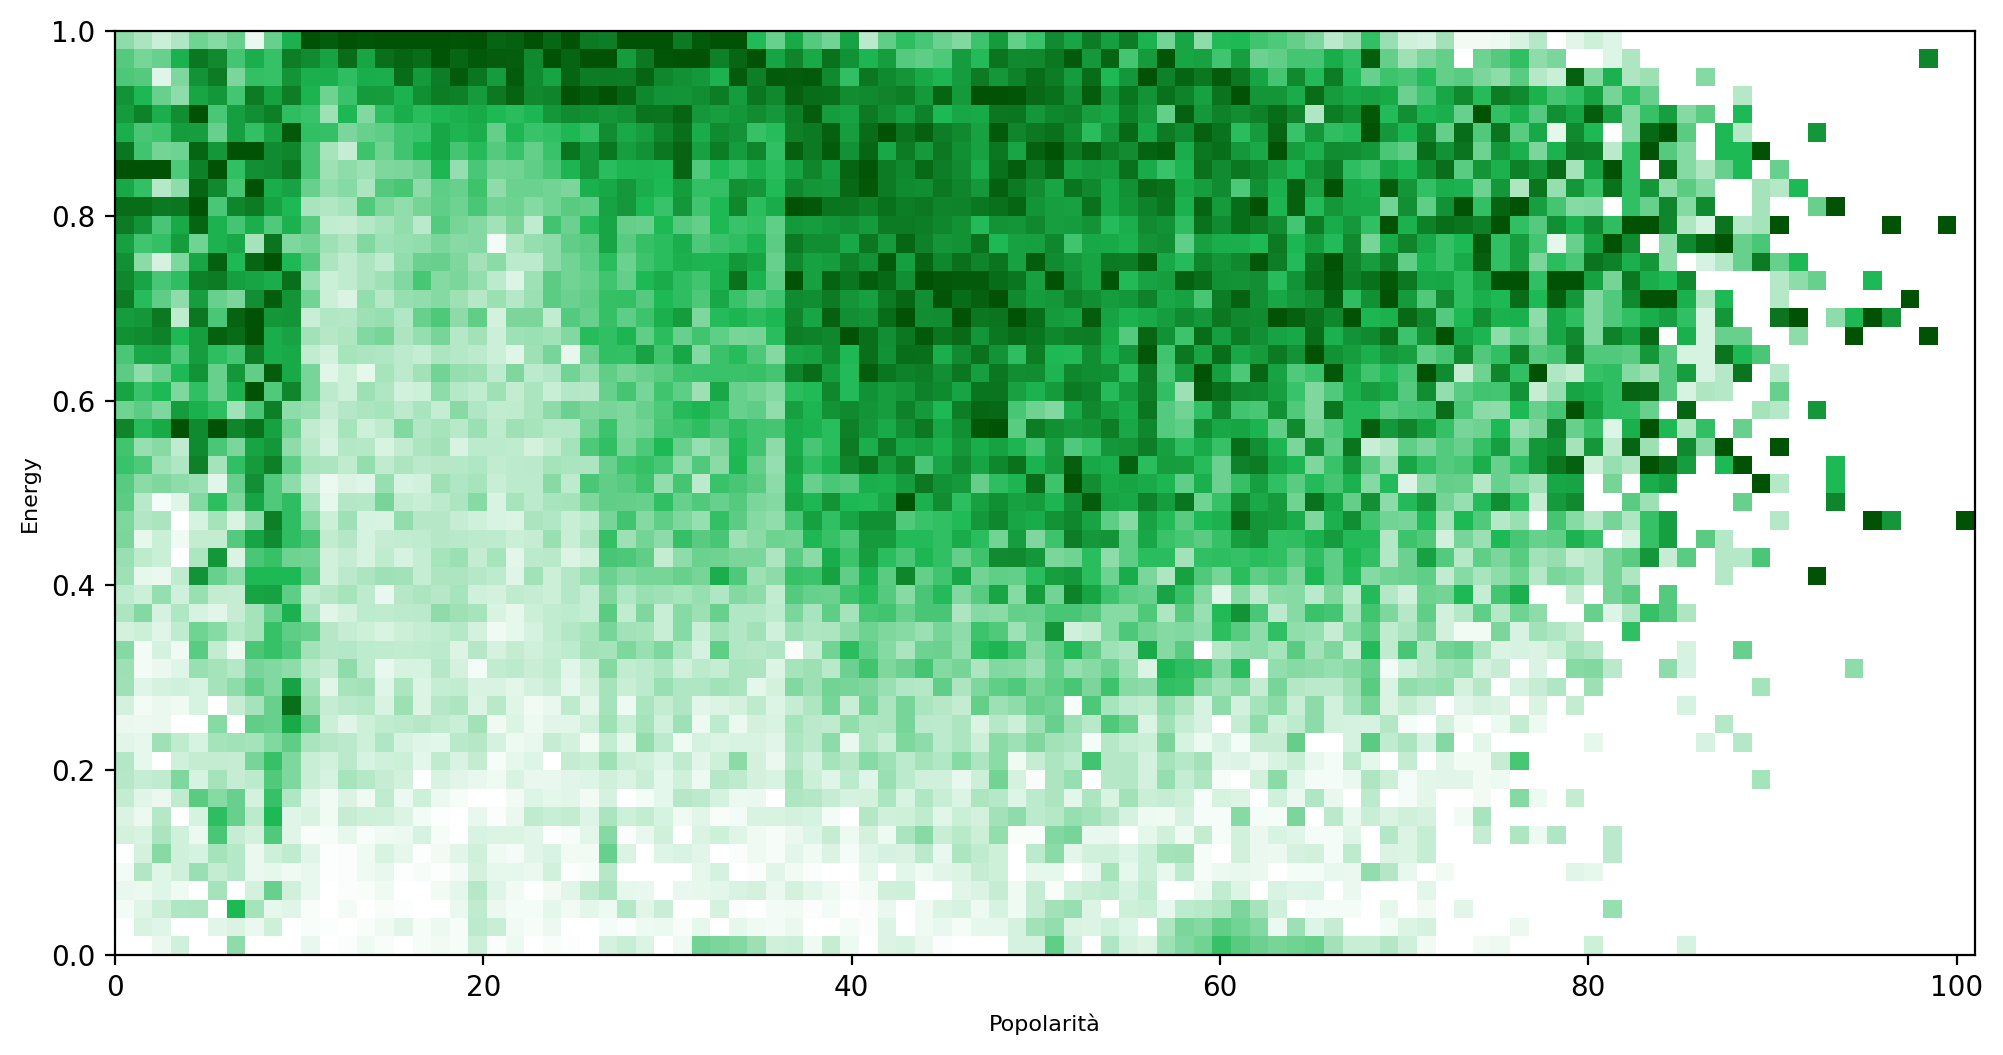

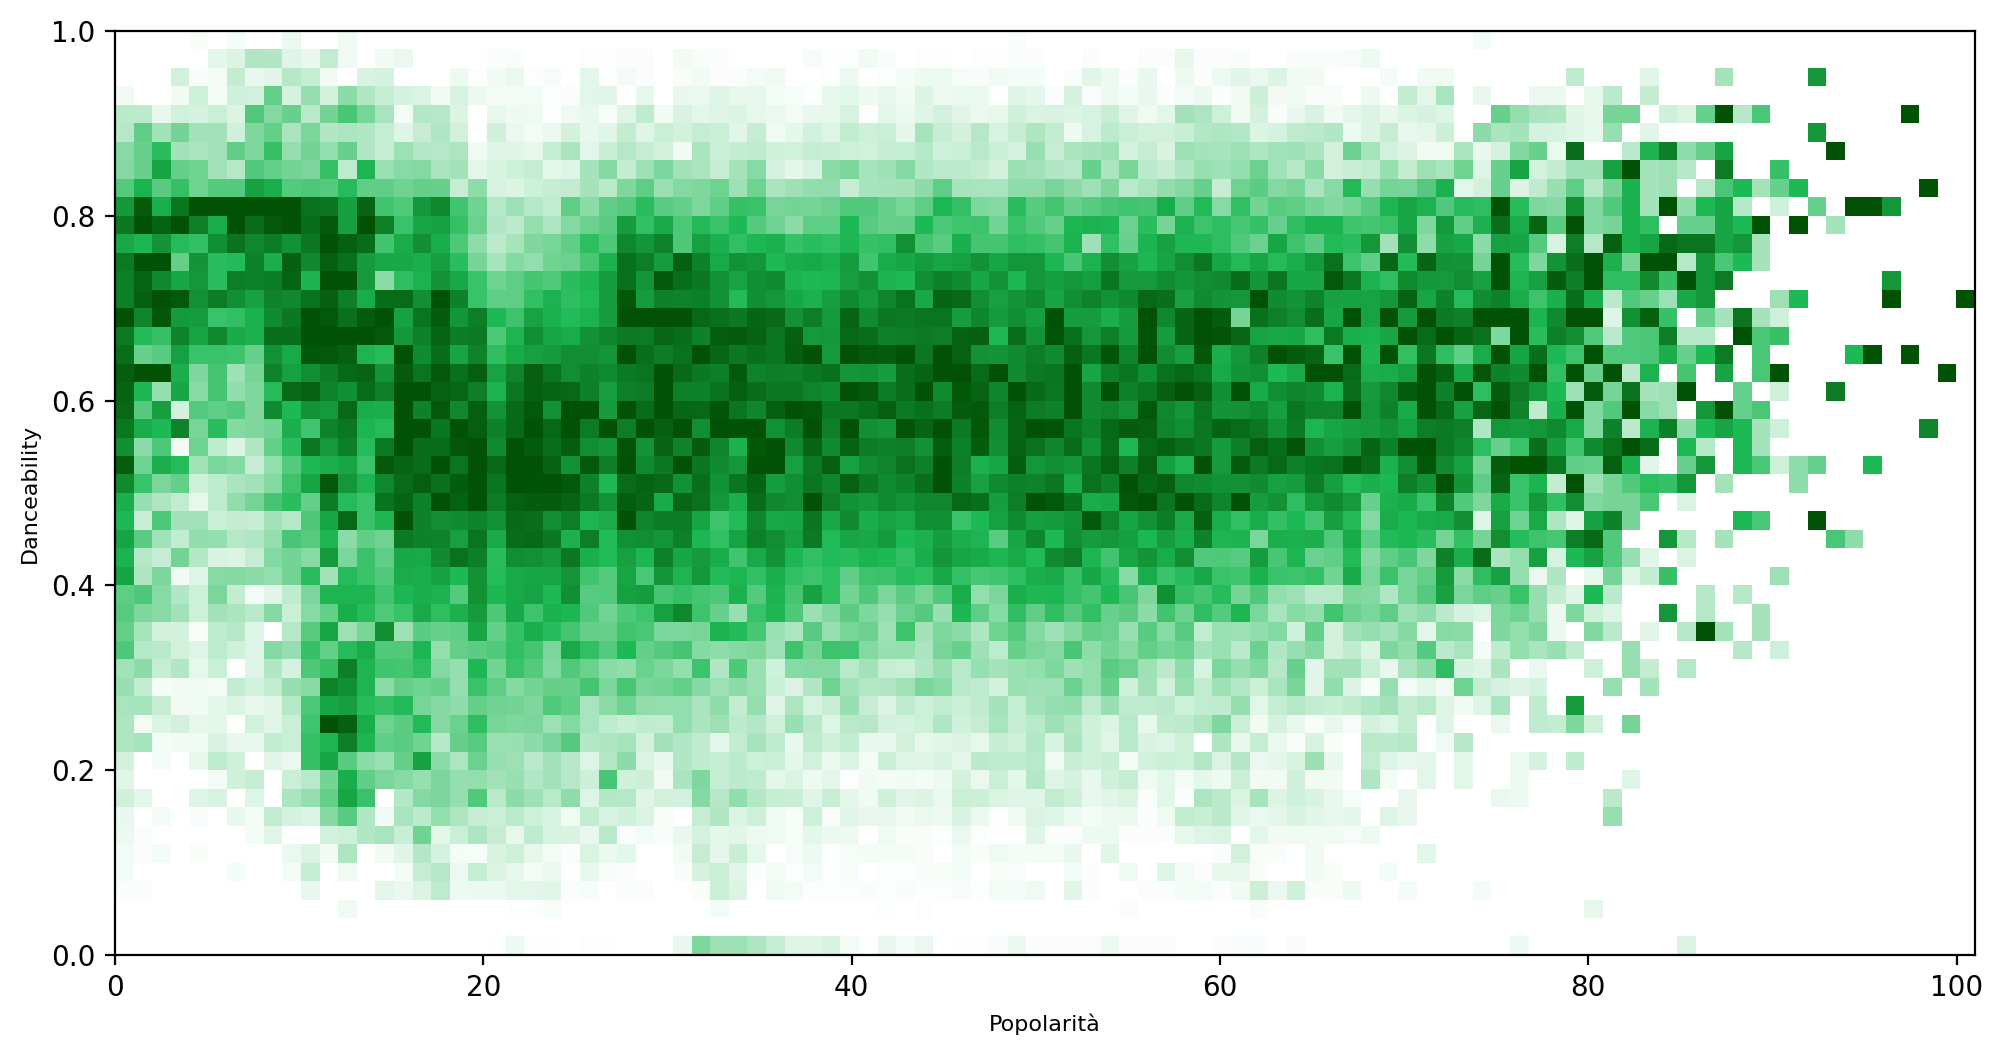

In [54]:

plot_heatmap(df, 'energy')
plot_heatmap(df, 'danceability')

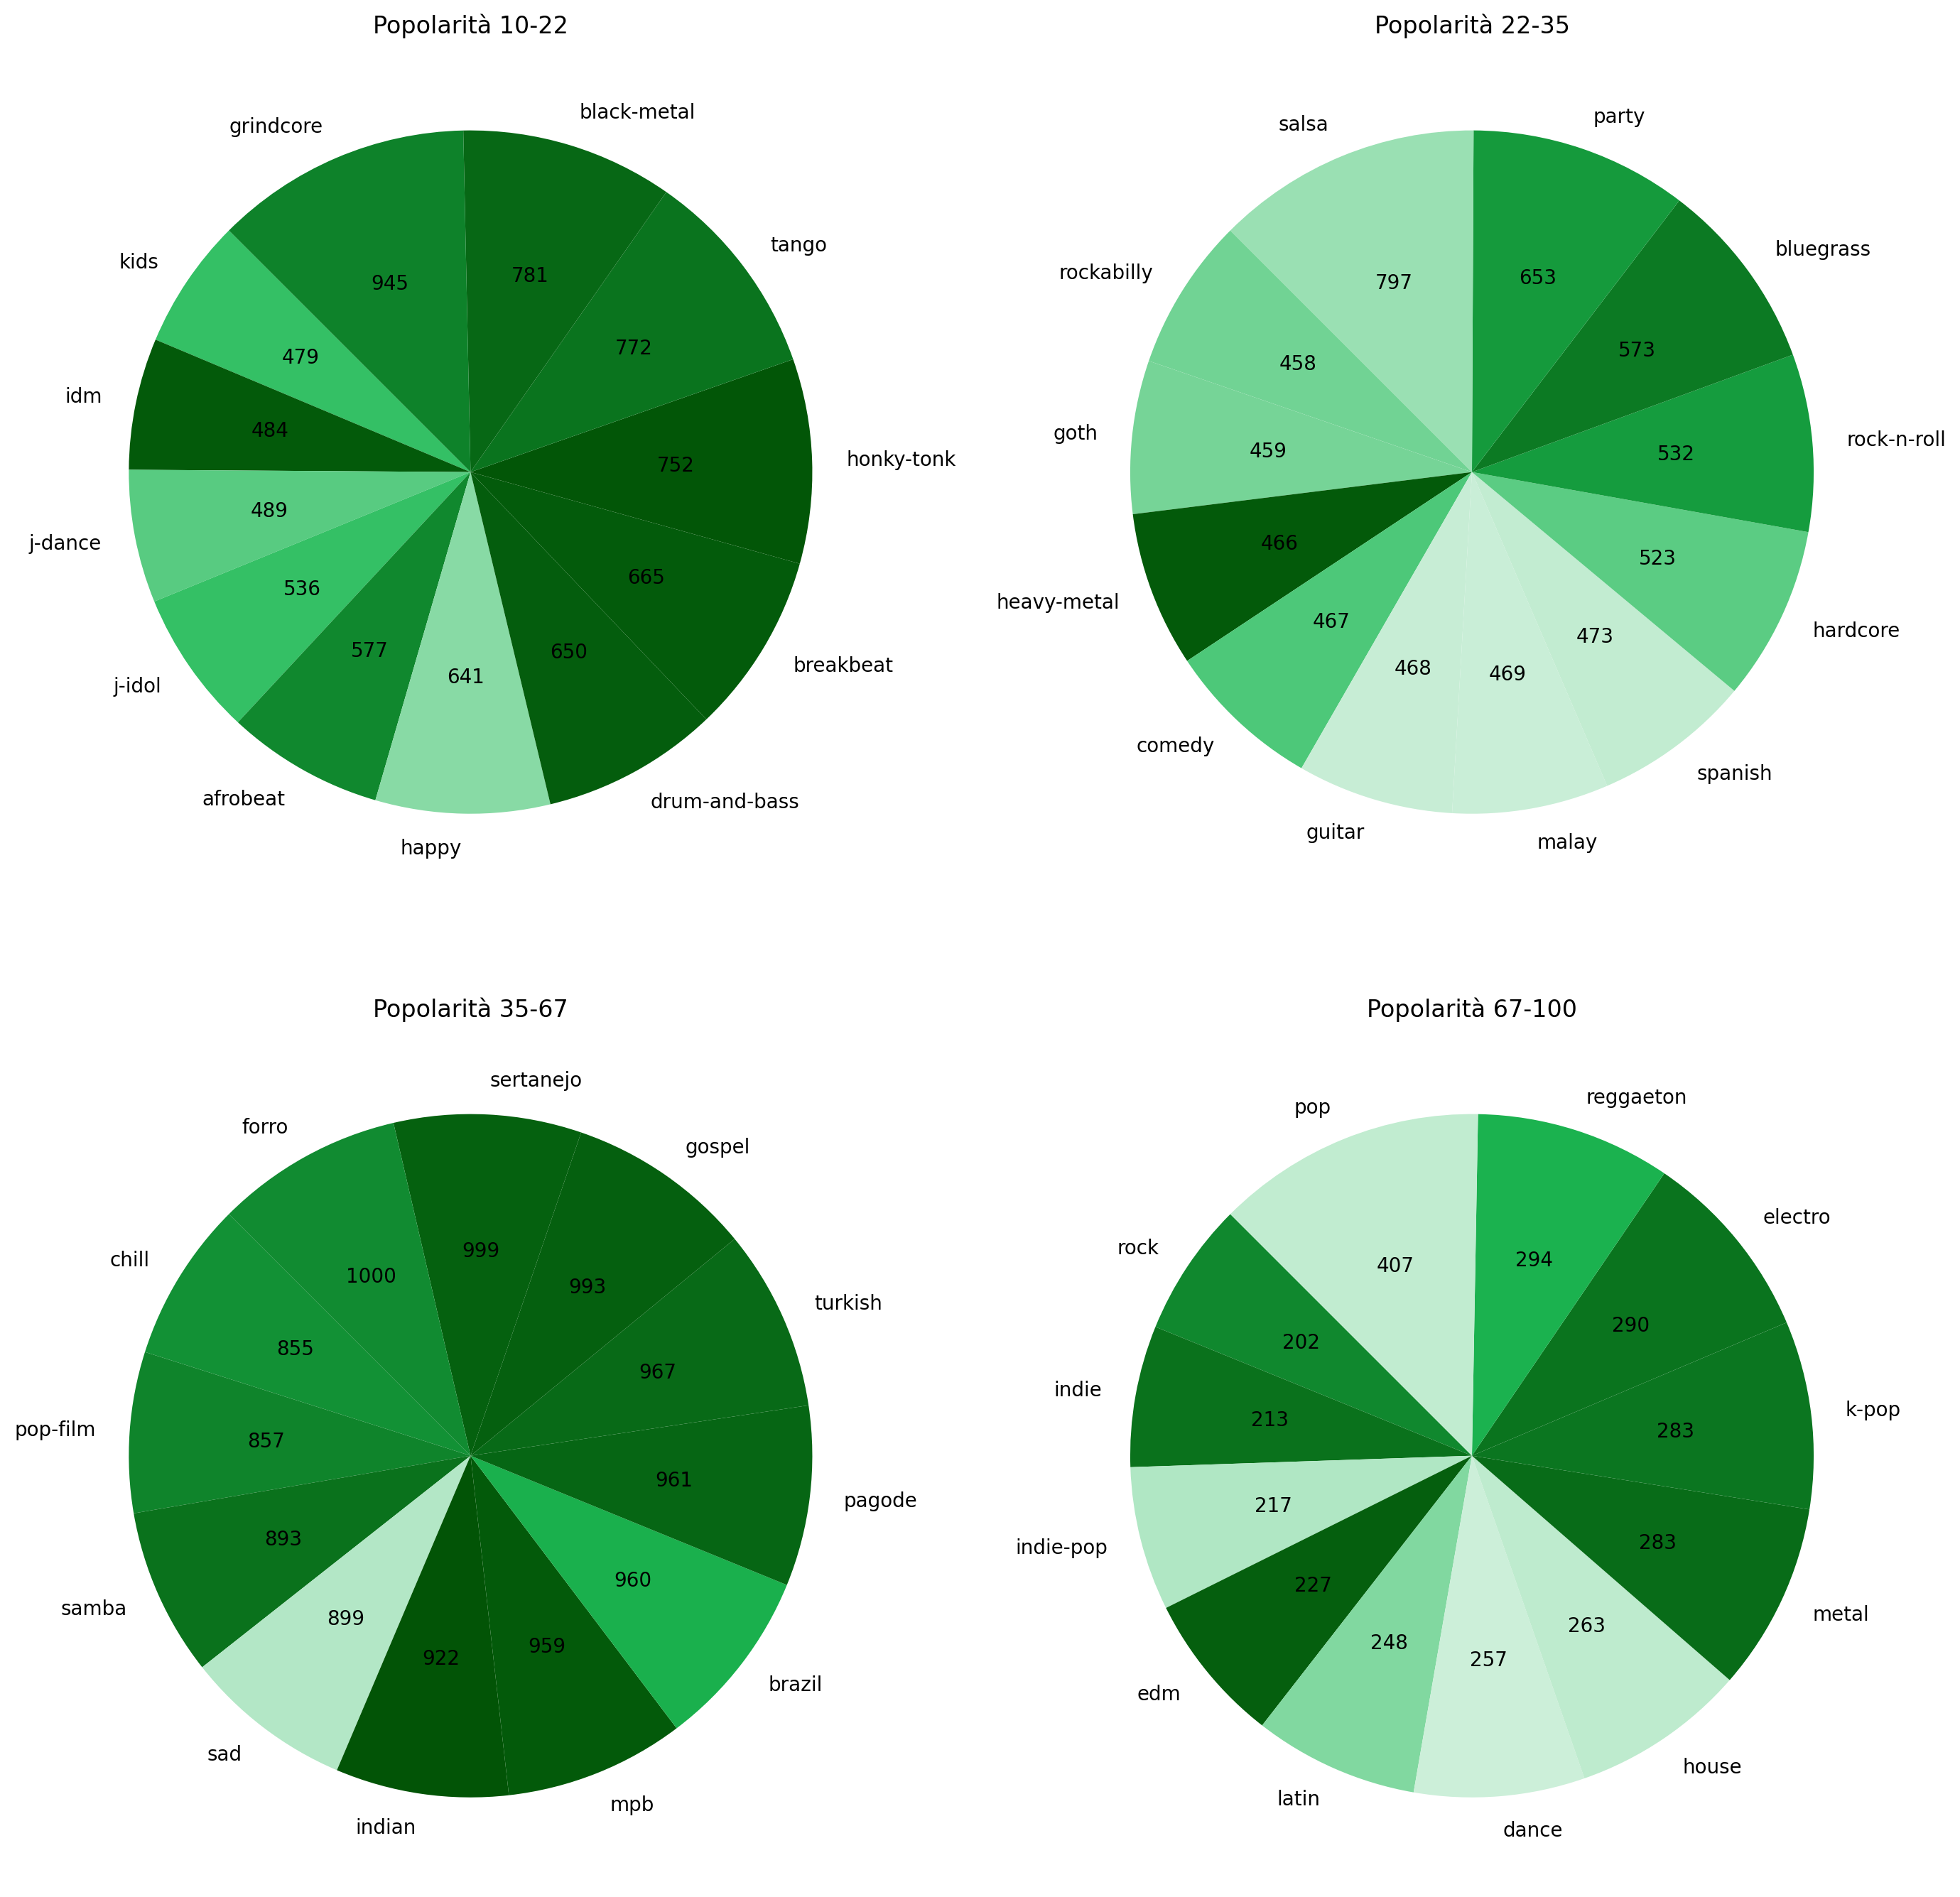

In [8]:
# Quali sono i generi delle canzoni più popolari, per fascia?

# le quattro fasce
df1 = df[(df[popularity] > 10) & (df[popularity] <= 22)].copy()
df2 = df[(df[popularity] > 22) & (df[popularity] <= 35)].copy()
df3 = df[(df[popularity] > 35) & (df[popularity] <= 67)].copy()
df4 = df[(df[popularity] > 67) & (df[popularity] <= 100)].copy()

# Function to process and create pie chart for given dataset
def create_pie_chart(df_filtered, title, ax):
    # selezioniamo solo i generi molto rappresentati all'interno di ciascuna fascia 
    genre_counts = df_filtered[genre].value_counts(ascending=True).tail(12)
    df_filtered = df_filtered[df_filtered[genre].isin(genre_counts.index)].copy()

    custom_colors = ['#cff0db', '#1DB954', '#015204']
    colormap = pltc.LinearSegmentedColormap.from_list('custom_cmap', custom_colors)

    colors = [colormap((hash(i)*32 % 0xFFFFFF) / 0xFFFFFF) for i in genre_counts.index]

    def absolute_autopct(pct):
        total = sum(genre_counts)
        absolute = int(round(pct / 100. * total))
        return f'{absolute:d}'

    ax.pie(genre_counts, labels=genre_counts.index, autopct=absolute_autopct, startangle=135, colors=colors)
    ax.set_title(title)

fig, ax = plt.subplots(2, 2, figsize=(14, 14))


create_pie_chart(df1, 'Popolarità 10-22', ax[0, 0])
create_pie_chart(df2, 'Popolarità 22-35', ax[0, 1])
create_pie_chart(df3, 'Popolarità 35-67', ax[1, 0])
create_pie_chart(df4, 'Popolarità 67-100', ax[1, 1])

plt.tight_layout()
plt.show()


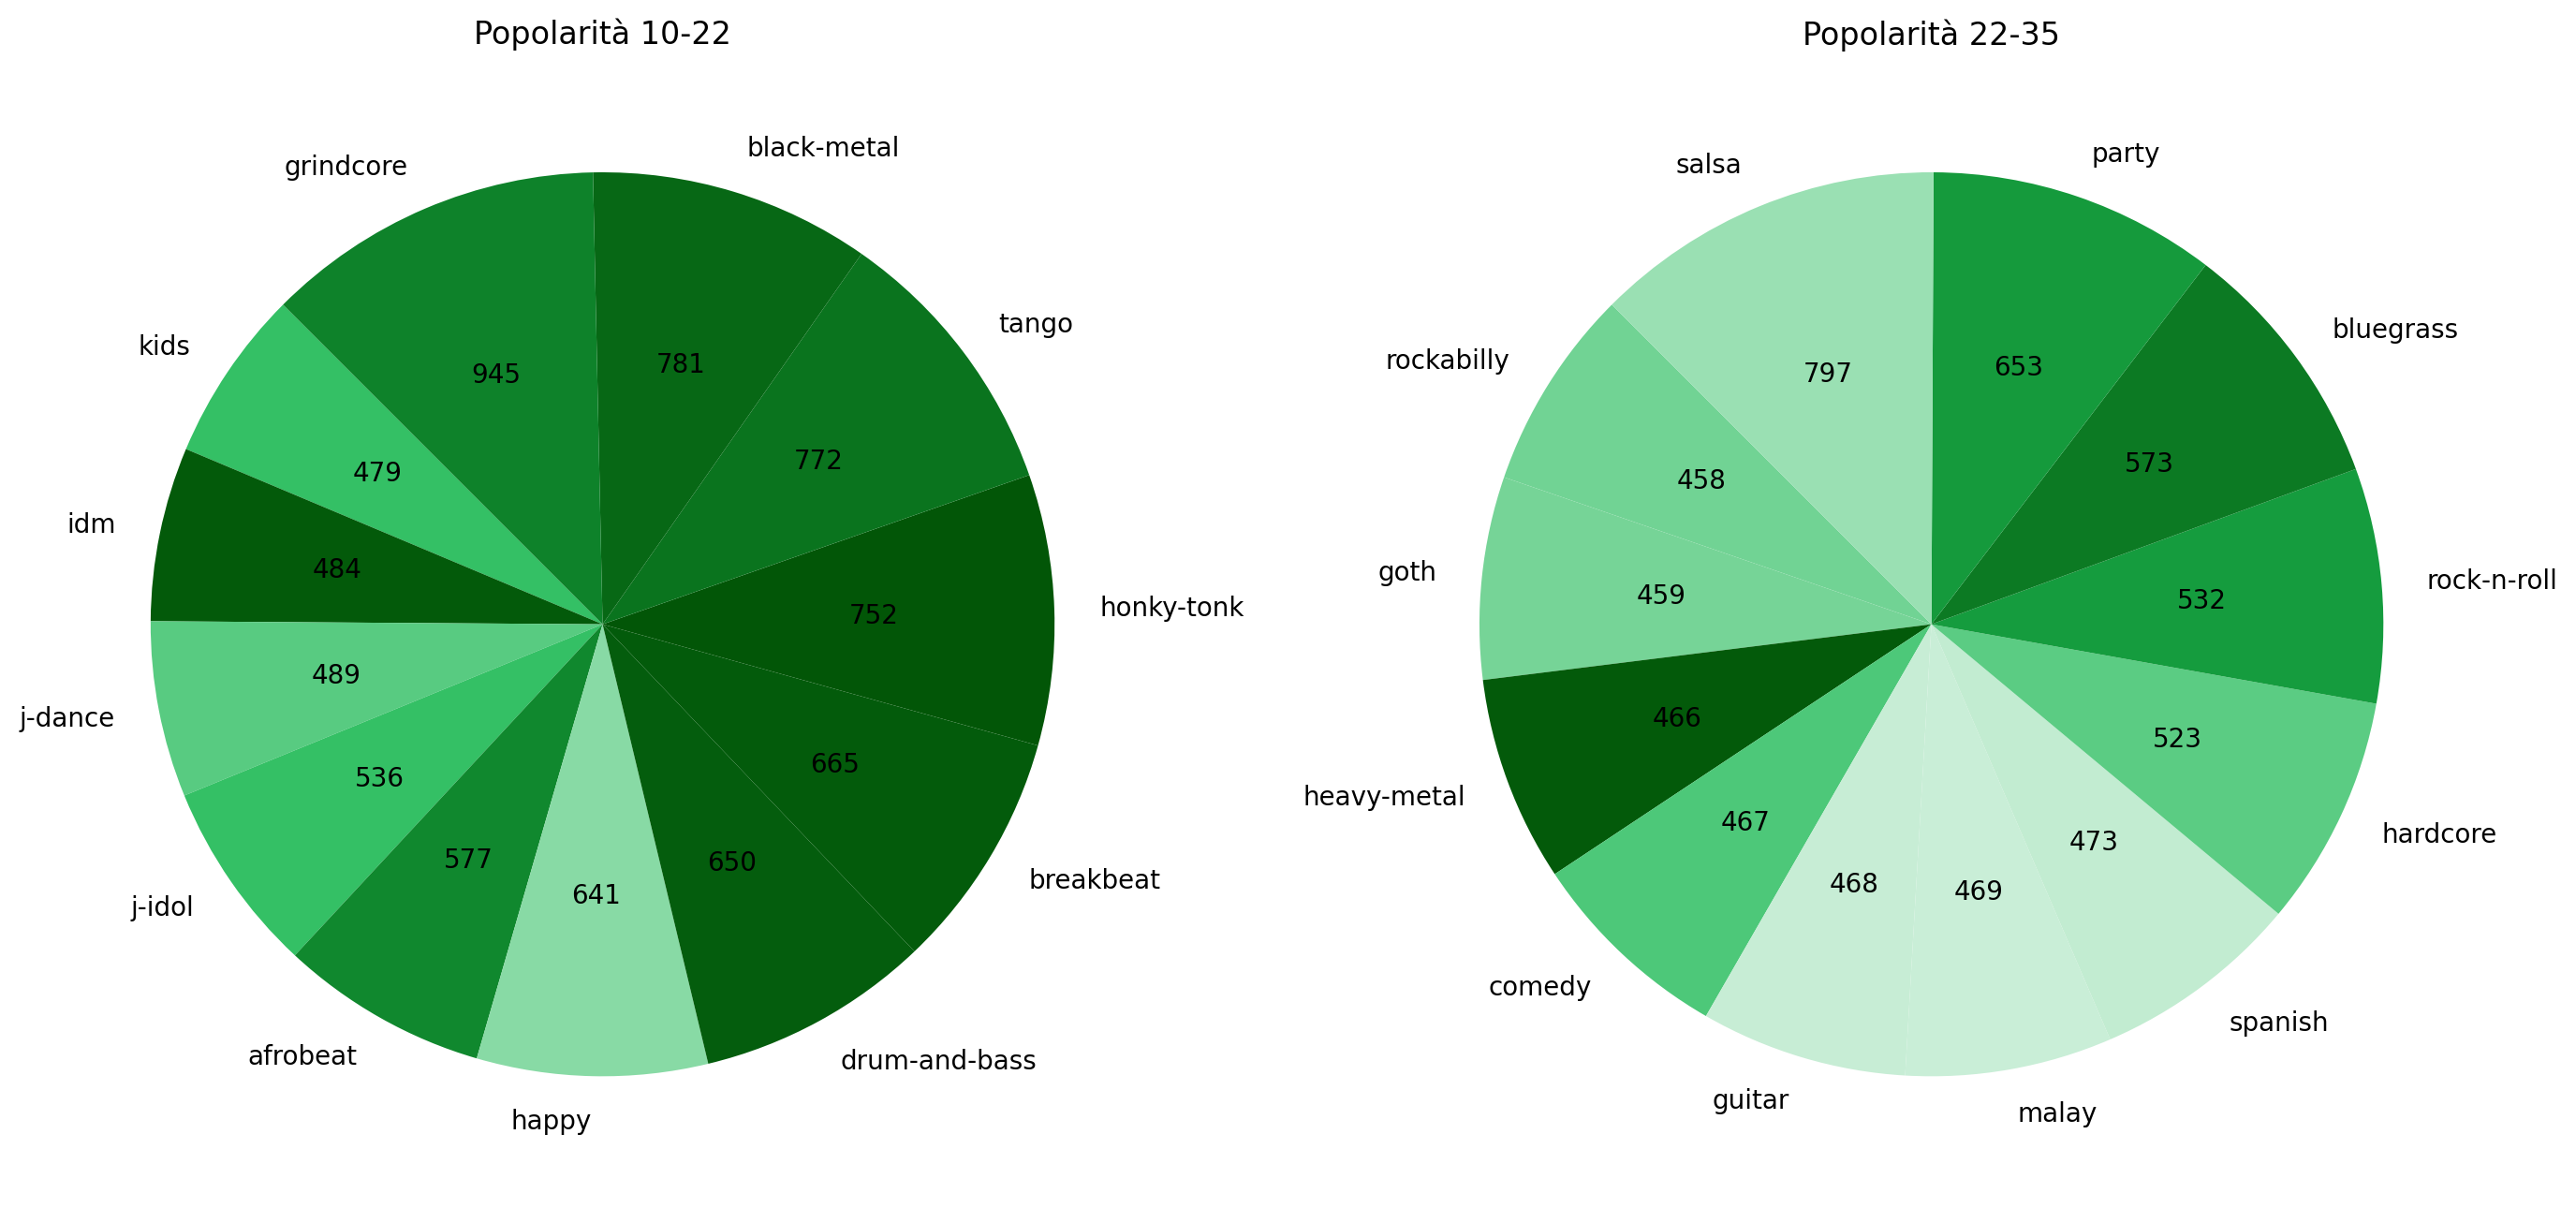

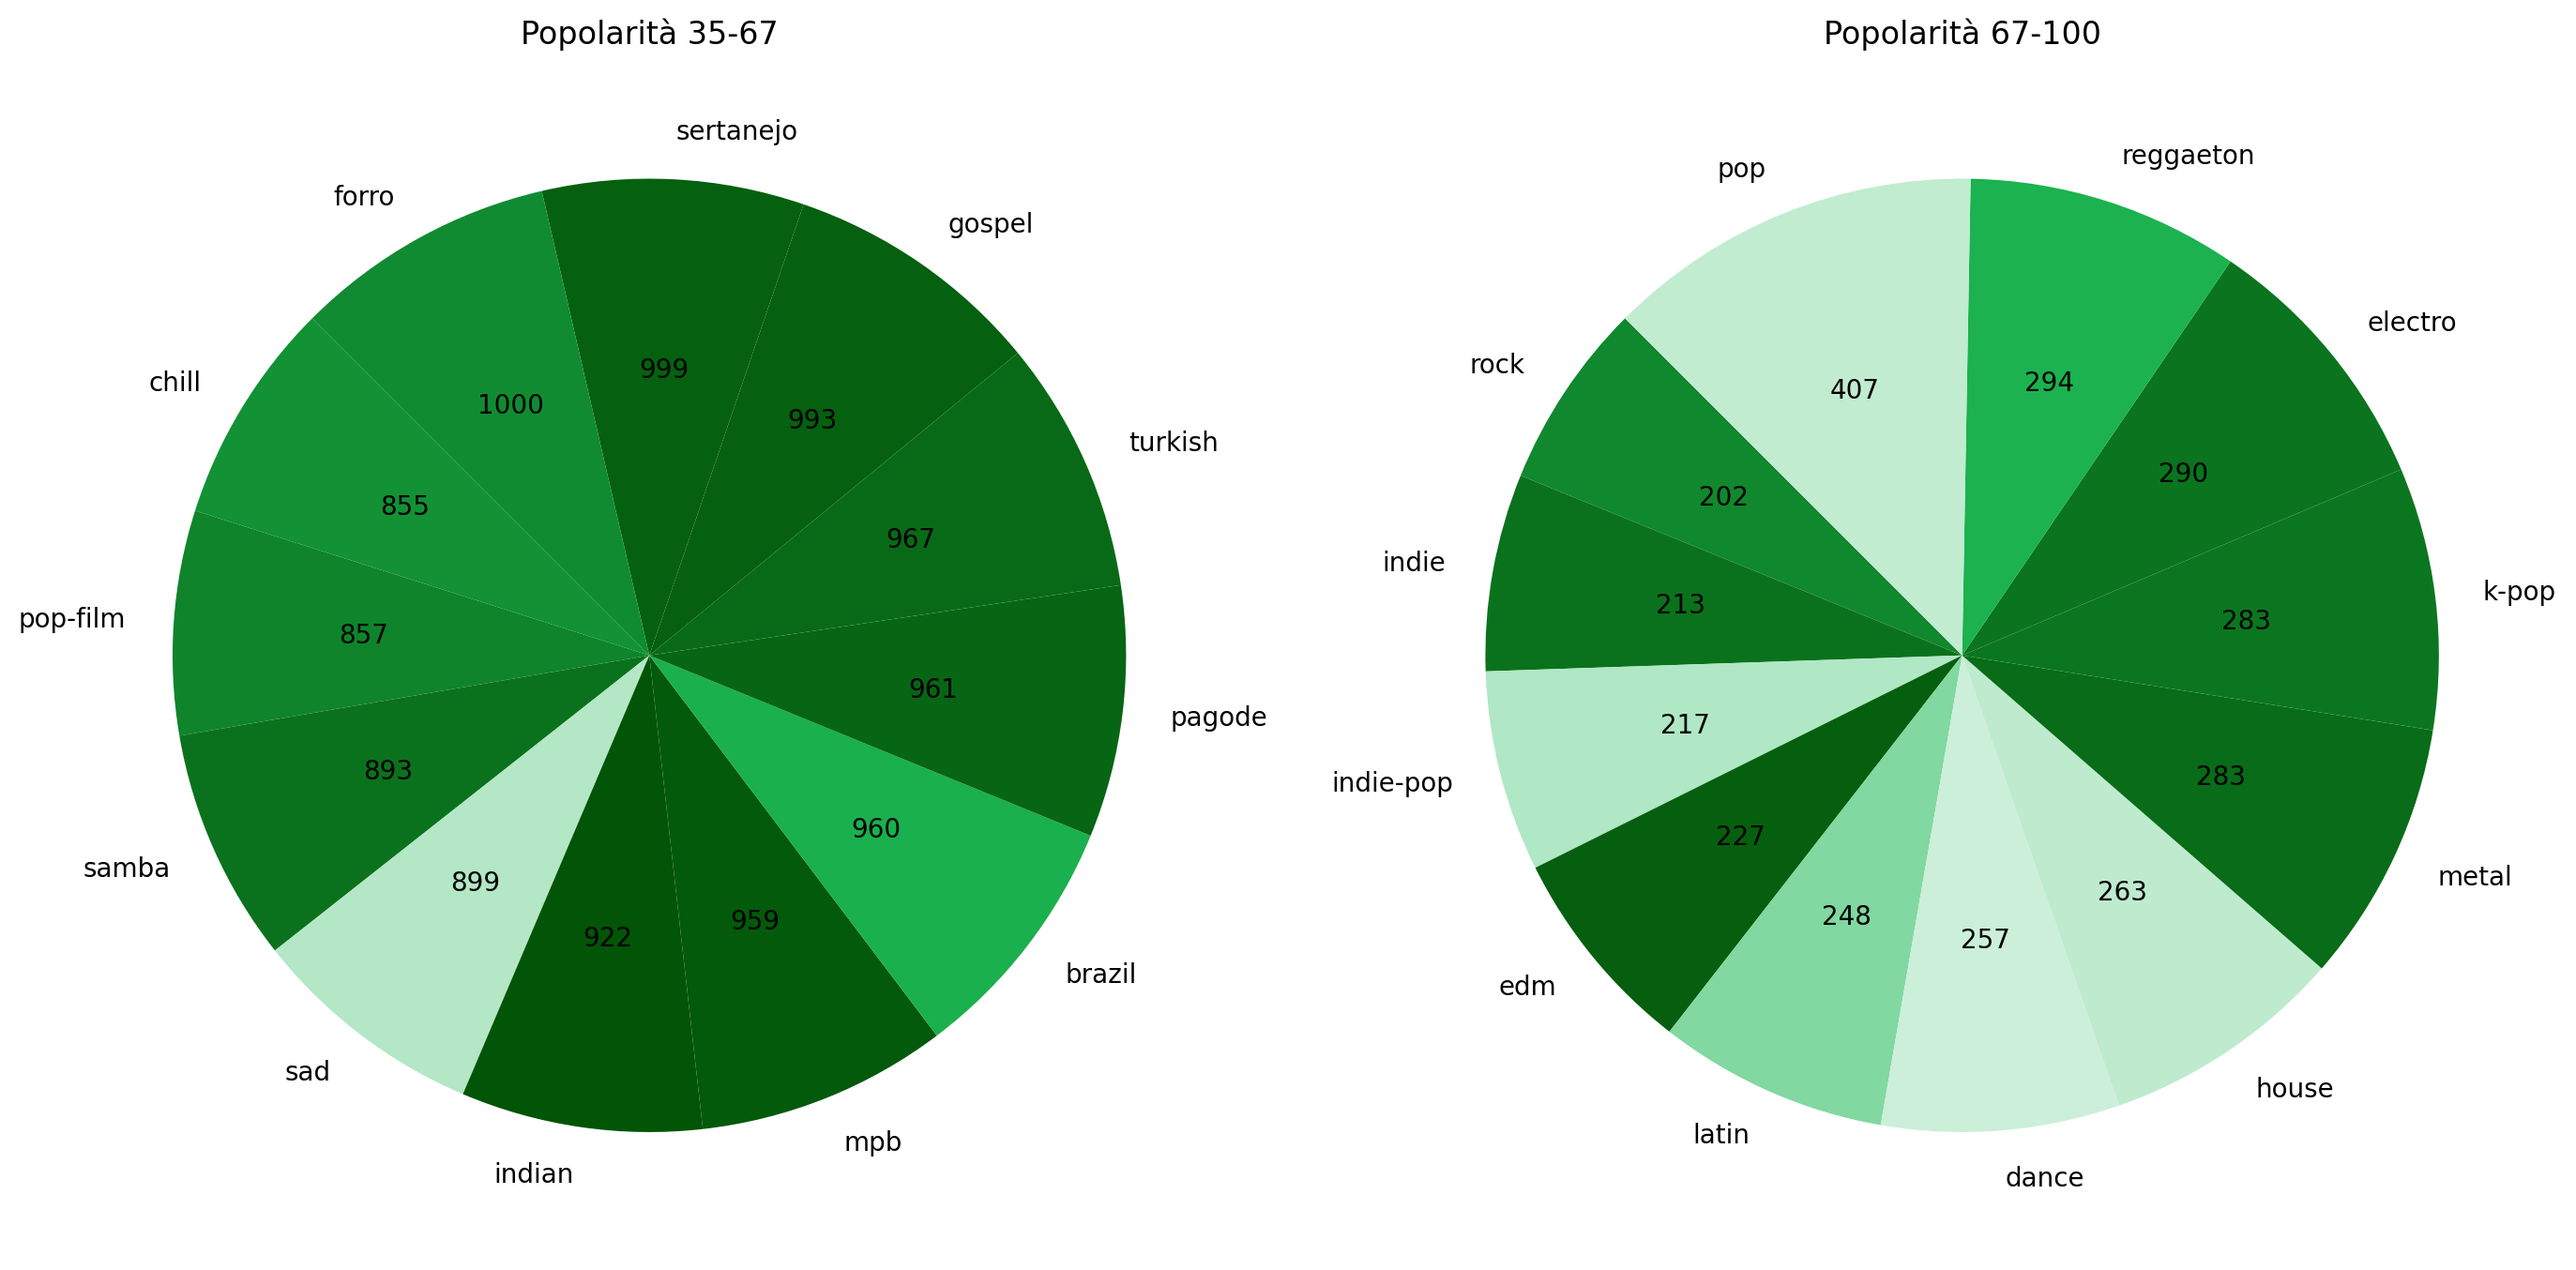

In [9]:
# Ripetiamo ma zoomando

df1 = df[(df[popularity] > 10) & (df[popularity] <= 22)].copy()
df2 = df[(df[popularity] > 22) & (df[popularity] <= 35)].copy()

fig, ax = plt.subplots(1, 2, figsize=(14, 14))

create_pie_chart(df1, 'Popolarità 10-22', ax[0])
create_pie_chart(df2, 'Popolarità 22-35', ax[1])

plt.tight_layout()
plt.show()

df3 = df[(df[popularity] > 35) & (df[popularity] <= 67)].copy()
df4 = df[(df[popularity] > 67) & (df[popularity] <= 100)].copy()

fig, ax = plt.subplots(1, 2, figsize=(14, 14))

create_pie_chart(df3, 'Popolarità 35-67', ax[0])
create_pie_chart(df4, 'Popolarità 67-100', ax[1])

plt.tight_layout()
plt.show()

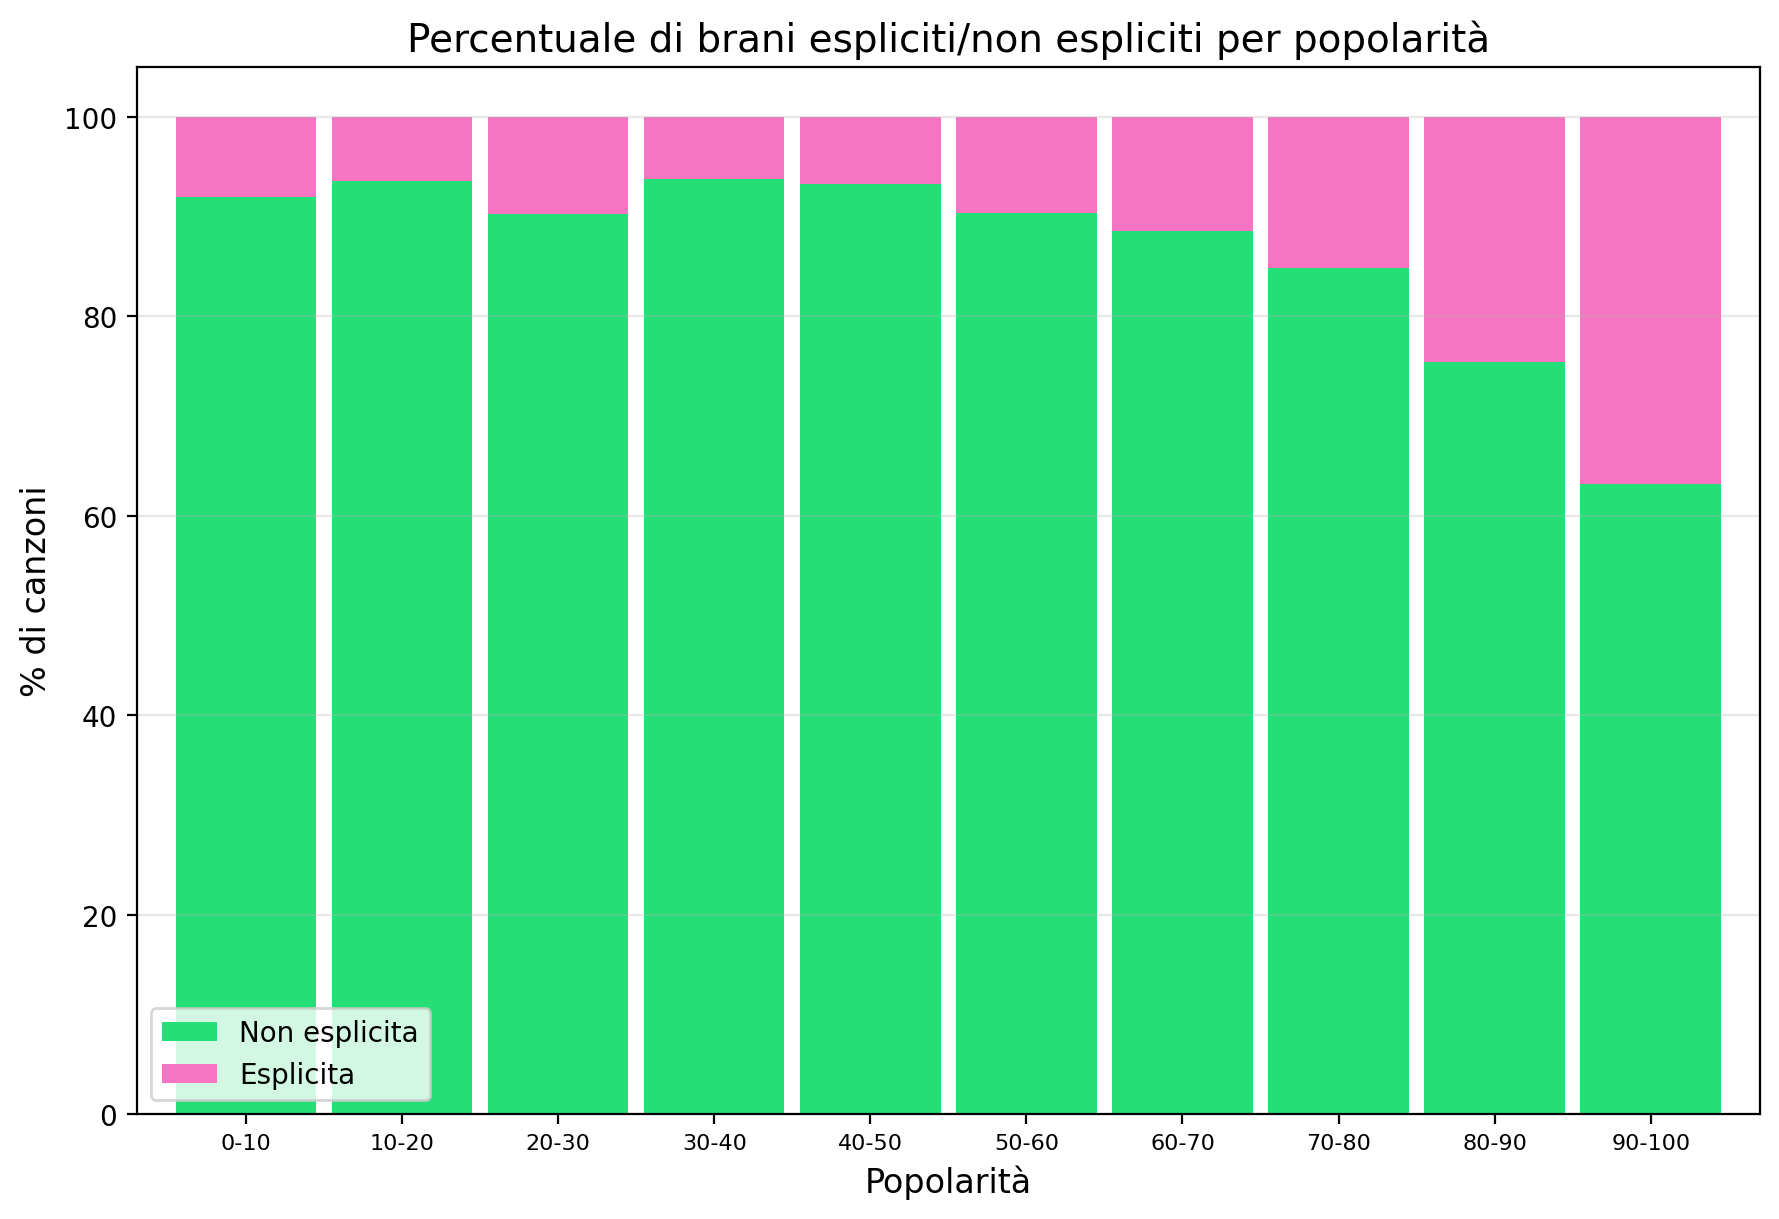

In [102]:
# definiamo fasce
popularity_bins = np.arange(0, 101, 10)
popularity_labels = [f"{i}-{i+10}" for i in range(0, 100, 10)]

# filtriamo per fascia
df_filtered = df.copy()
df_filtered['popularity_range'] = pd.cut(df_filtered['popularity'], bins=popularity_bins, labels=popularity_labels, include_lowest=True)

popularity_explicit_counts = df_filtered.groupby(['popularity_range', 'explicit']).size().unstack(fill_value=0)
popularity_explicit_percentages = popularity_explicit_counts.div(popularity_explicit_counts.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(9, 6.2))

# stacked bar plot per evidenziare che sia l'una che l'altra sono importanti, col rosa e non un colore neutro
popularity_explicit_percentages.plot(kind='bar', stacked=True, ax=ax, color=[spotifygreen, '#f774c2'], width=0.9)

ax.set_title('Percentuale di brani espliciti/non espliciti per popolarità', fontsize=14)
ax.set_xlabel('Popolarità', fontsize=12)
ax.set_ylabel('% di canzoni', fontsize=12)

ax.legend(['Non esplicita', 'Esplicita'], loc='lower left')

plt.xticks(rotation=0, fontsize=8)

ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()

plt.show()


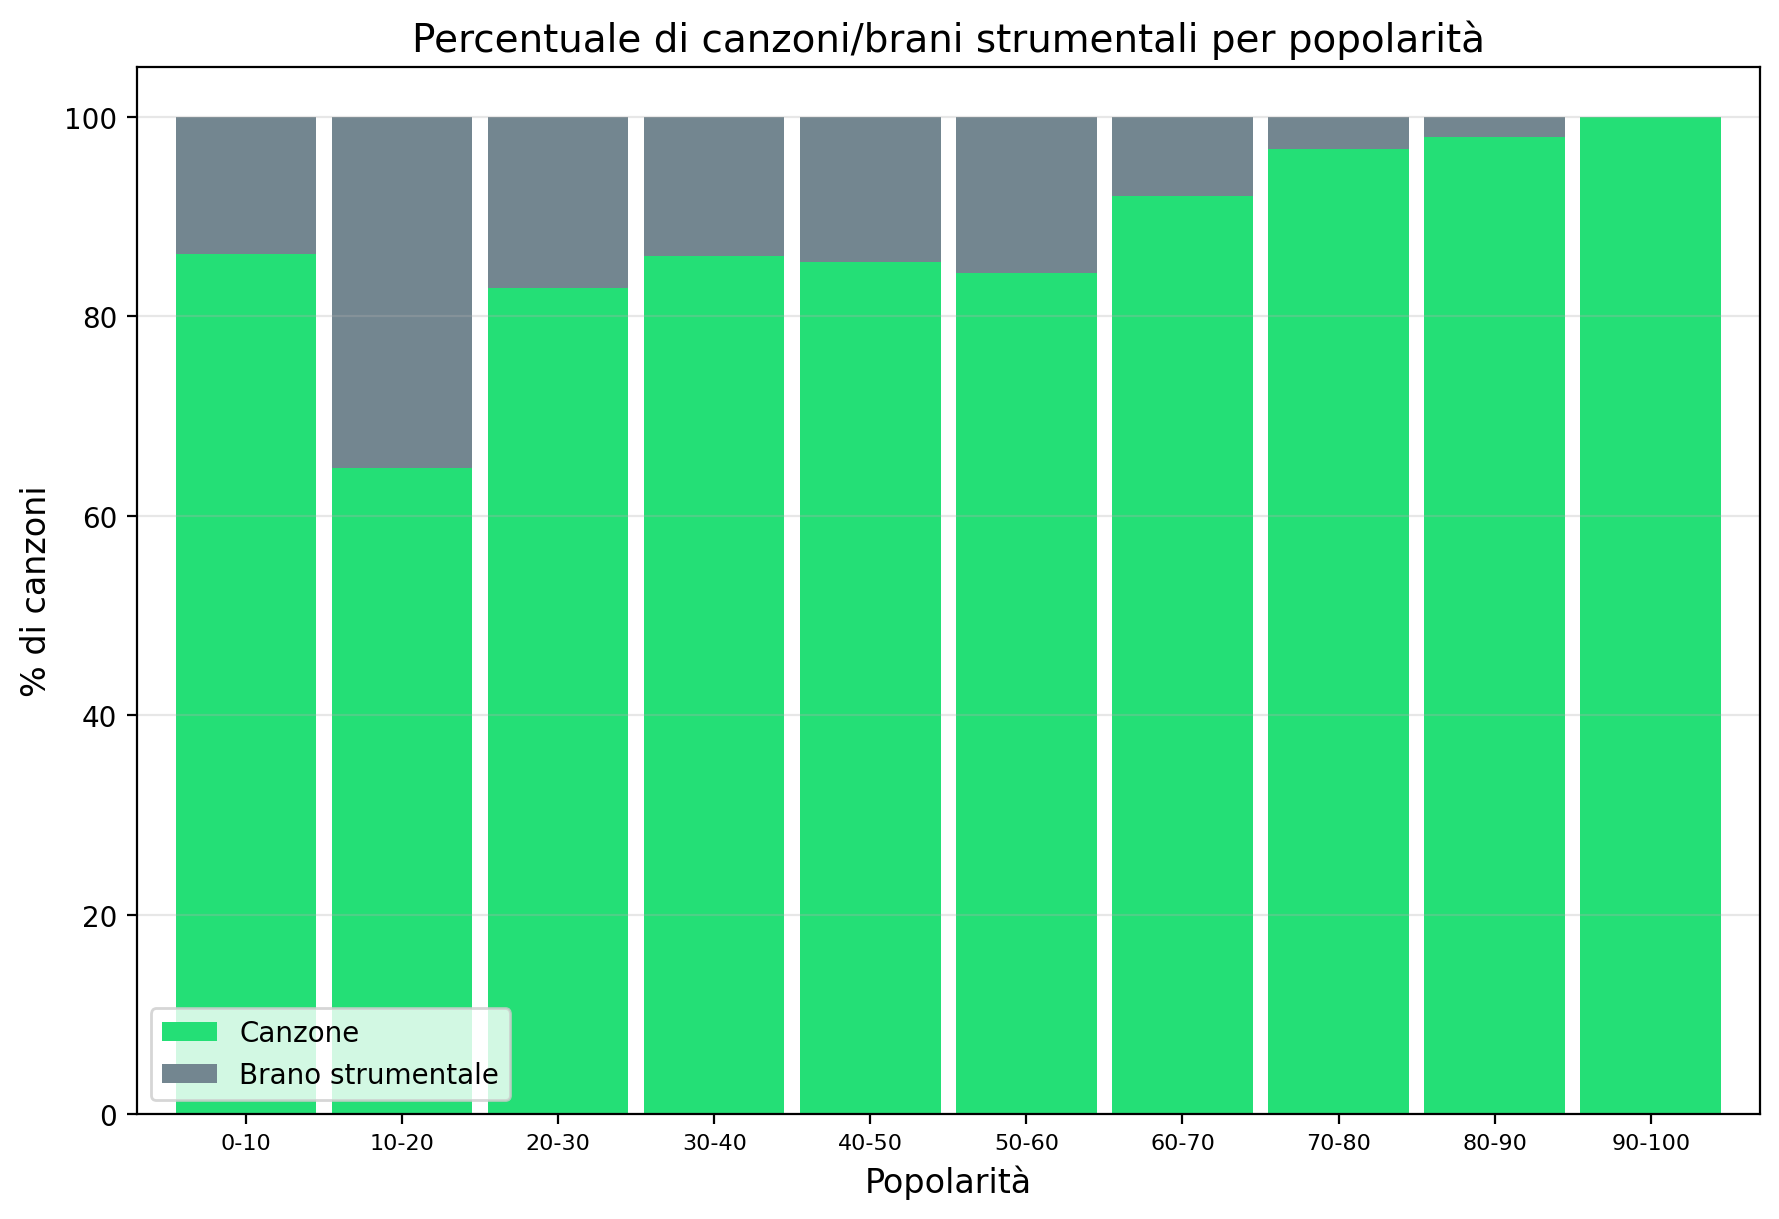

In [103]:
# continuiamo dal precedente

df_filtered['is_instrumental'] = df_filtered['instrumentalness'] > 0.5
instr_counts = df_filtered.groupby(['popularity_range', 'is_instrumental']).size().unstack(fill_value=0)
percent = instr_counts.div(instr_counts.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(9, 6.2))

# Questa volta usiamo un colore neutro perché in queste slide sto evidenziando che ci interessano le canzoni
percent.plot(kind='bar', stacked=True, ax=ax, color=[spotifygreen, '#738690'], width=0.9)

ax.set_title('Percentuale di canzoni/brani strumentali per popolarità', fontsize=14)
ax.set_xlabel('Popolarità', fontsize=12)
ax.set_ylabel('% di canzoni', fontsize=12)

ax.legend(['Canzone', 'Brano strumentale'], loc='lower left')

plt.xticks(rotation=0, fontsize=8)

ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()

plt.show()

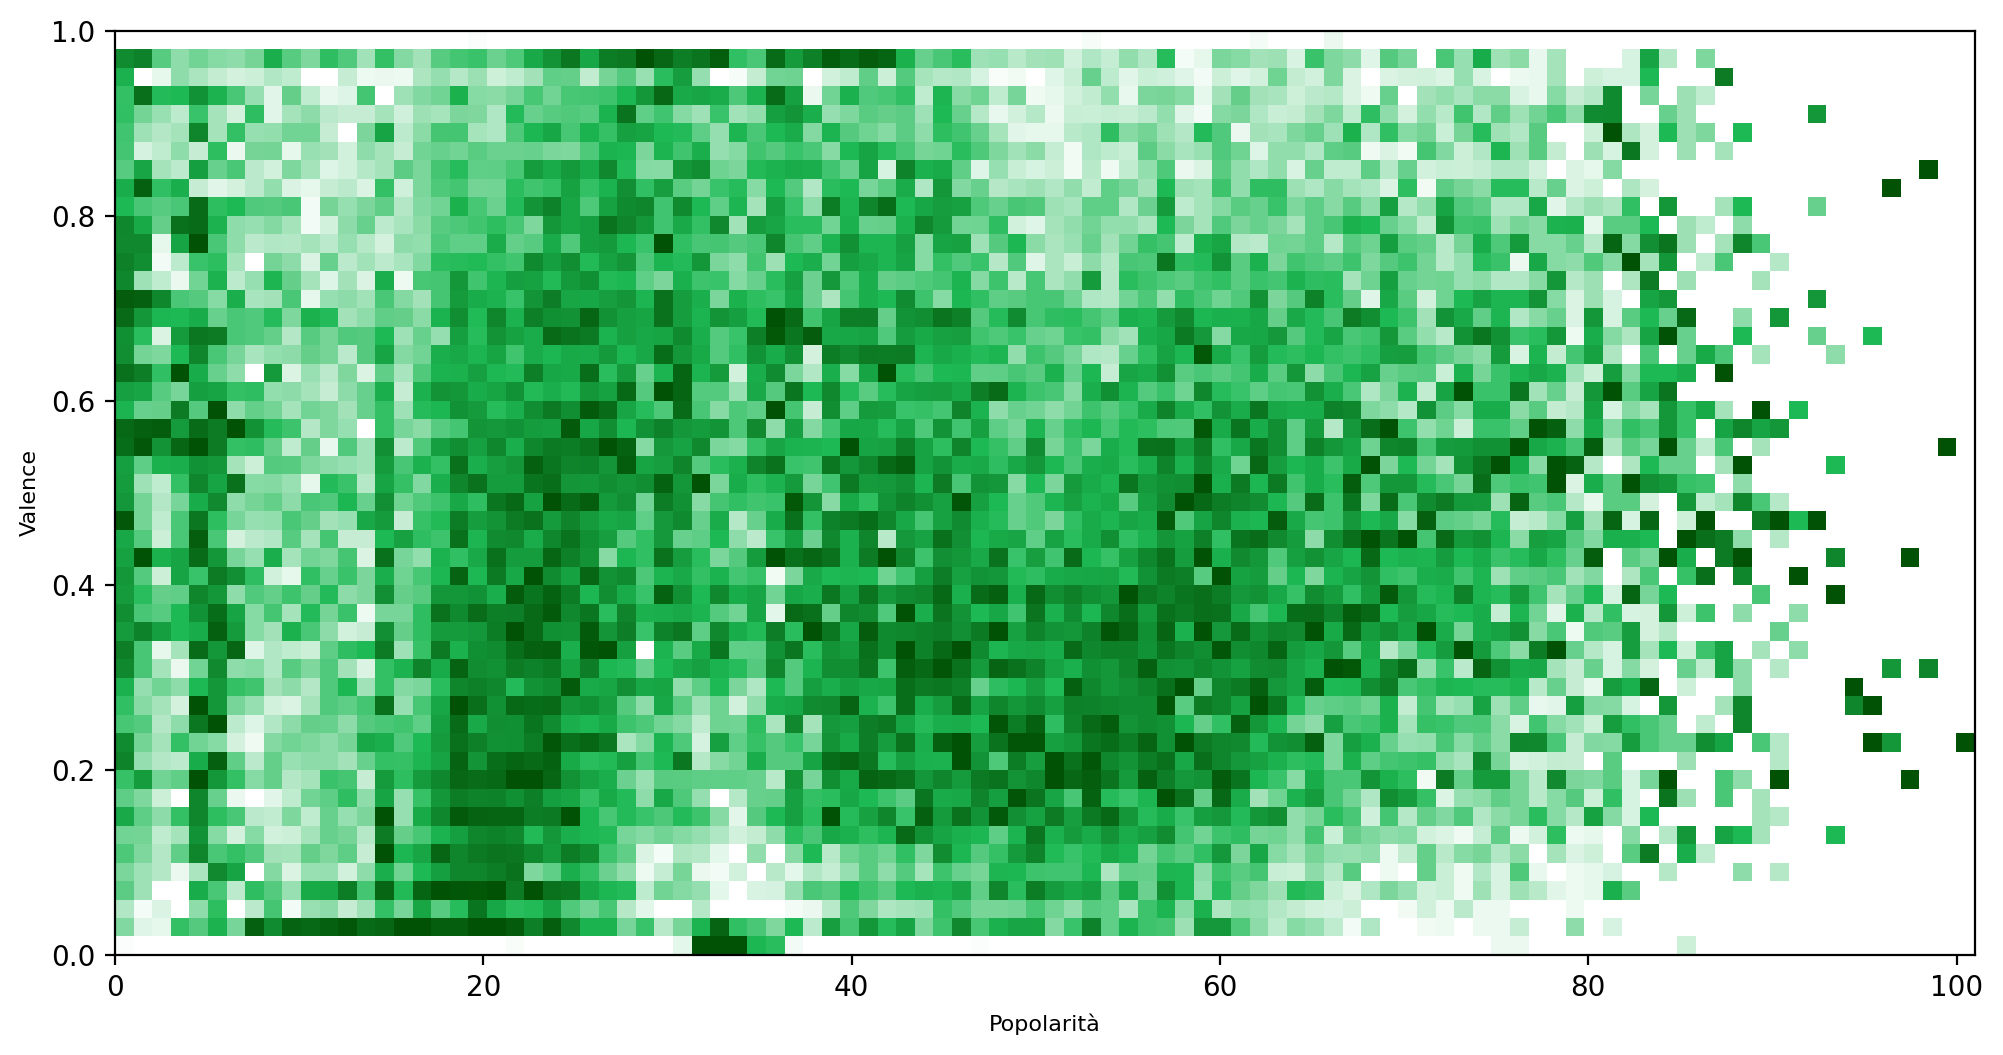

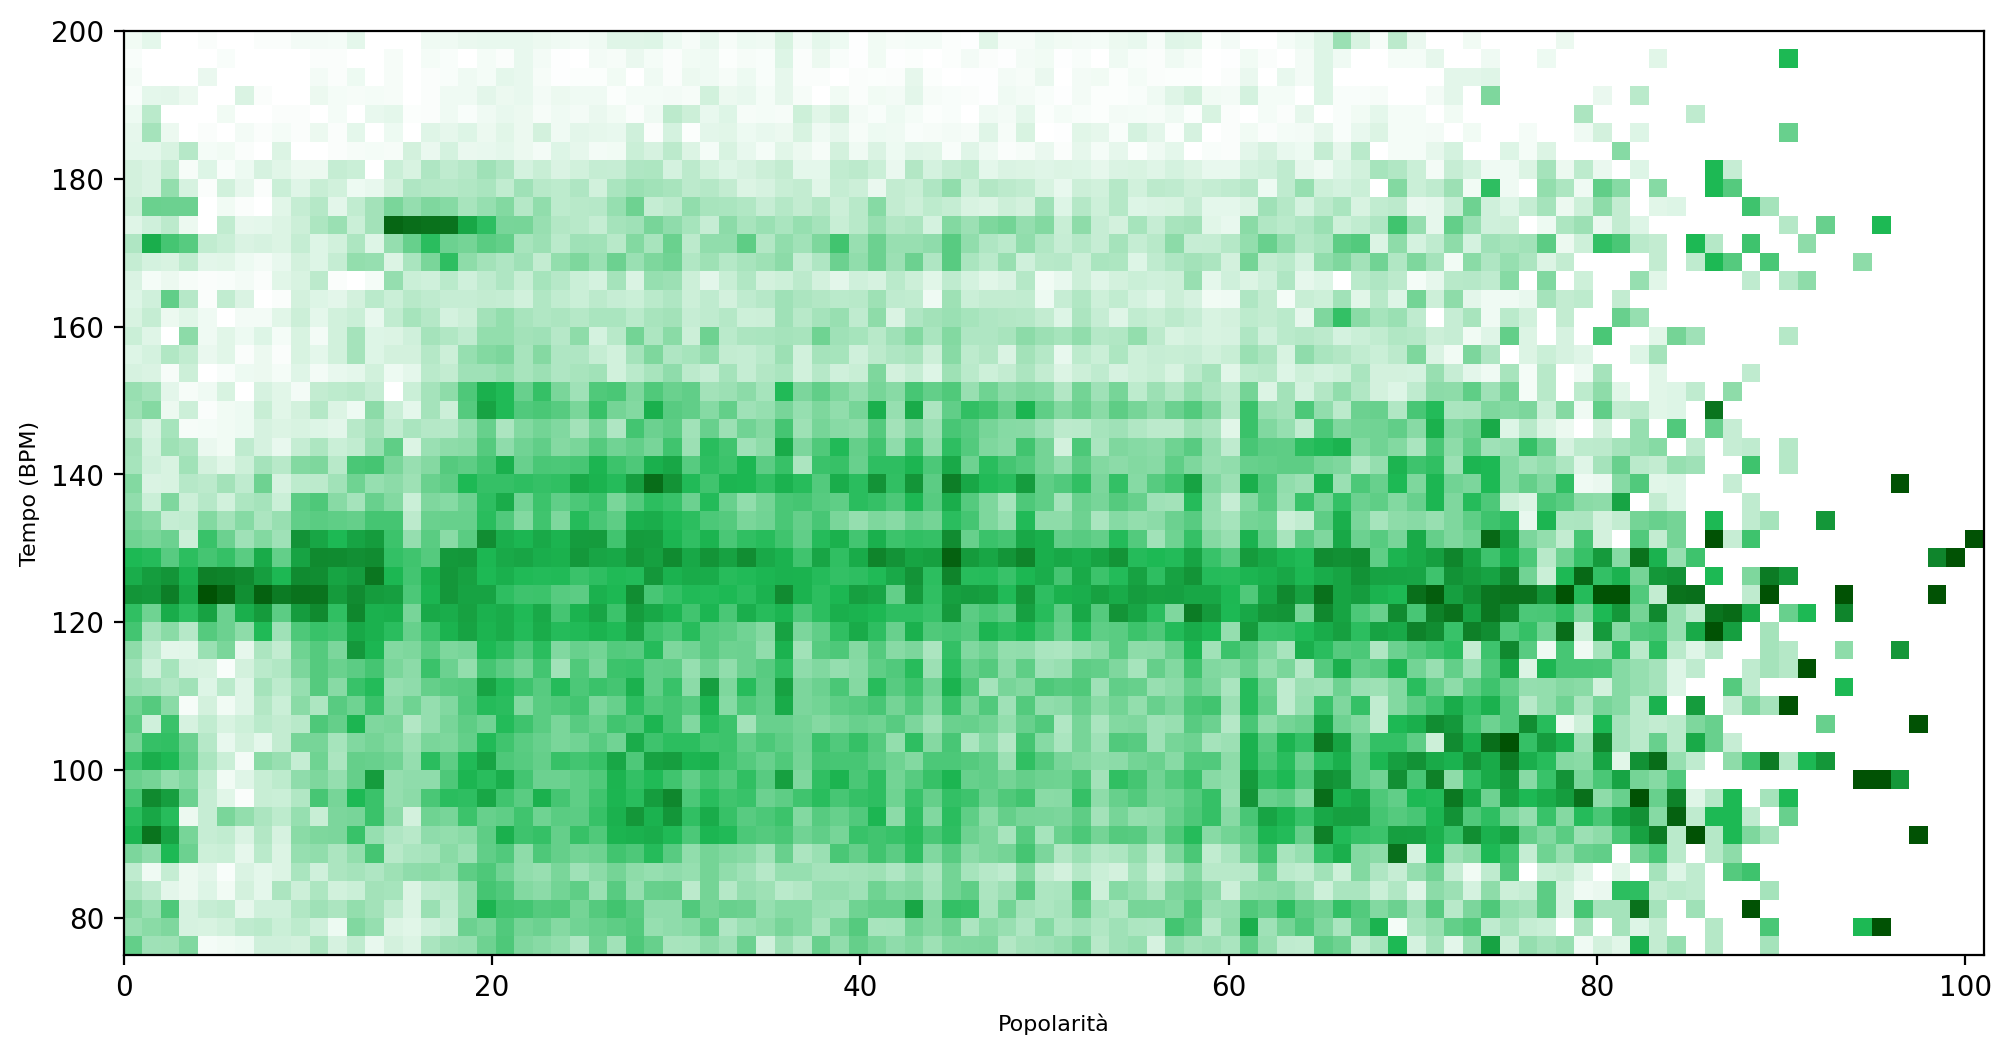

In [55]:
plot_heatmap(df, 'valence')
plot_heatmap(df, 'tempo', y_limits=(75,200), y_label='Tempo (BPM)')

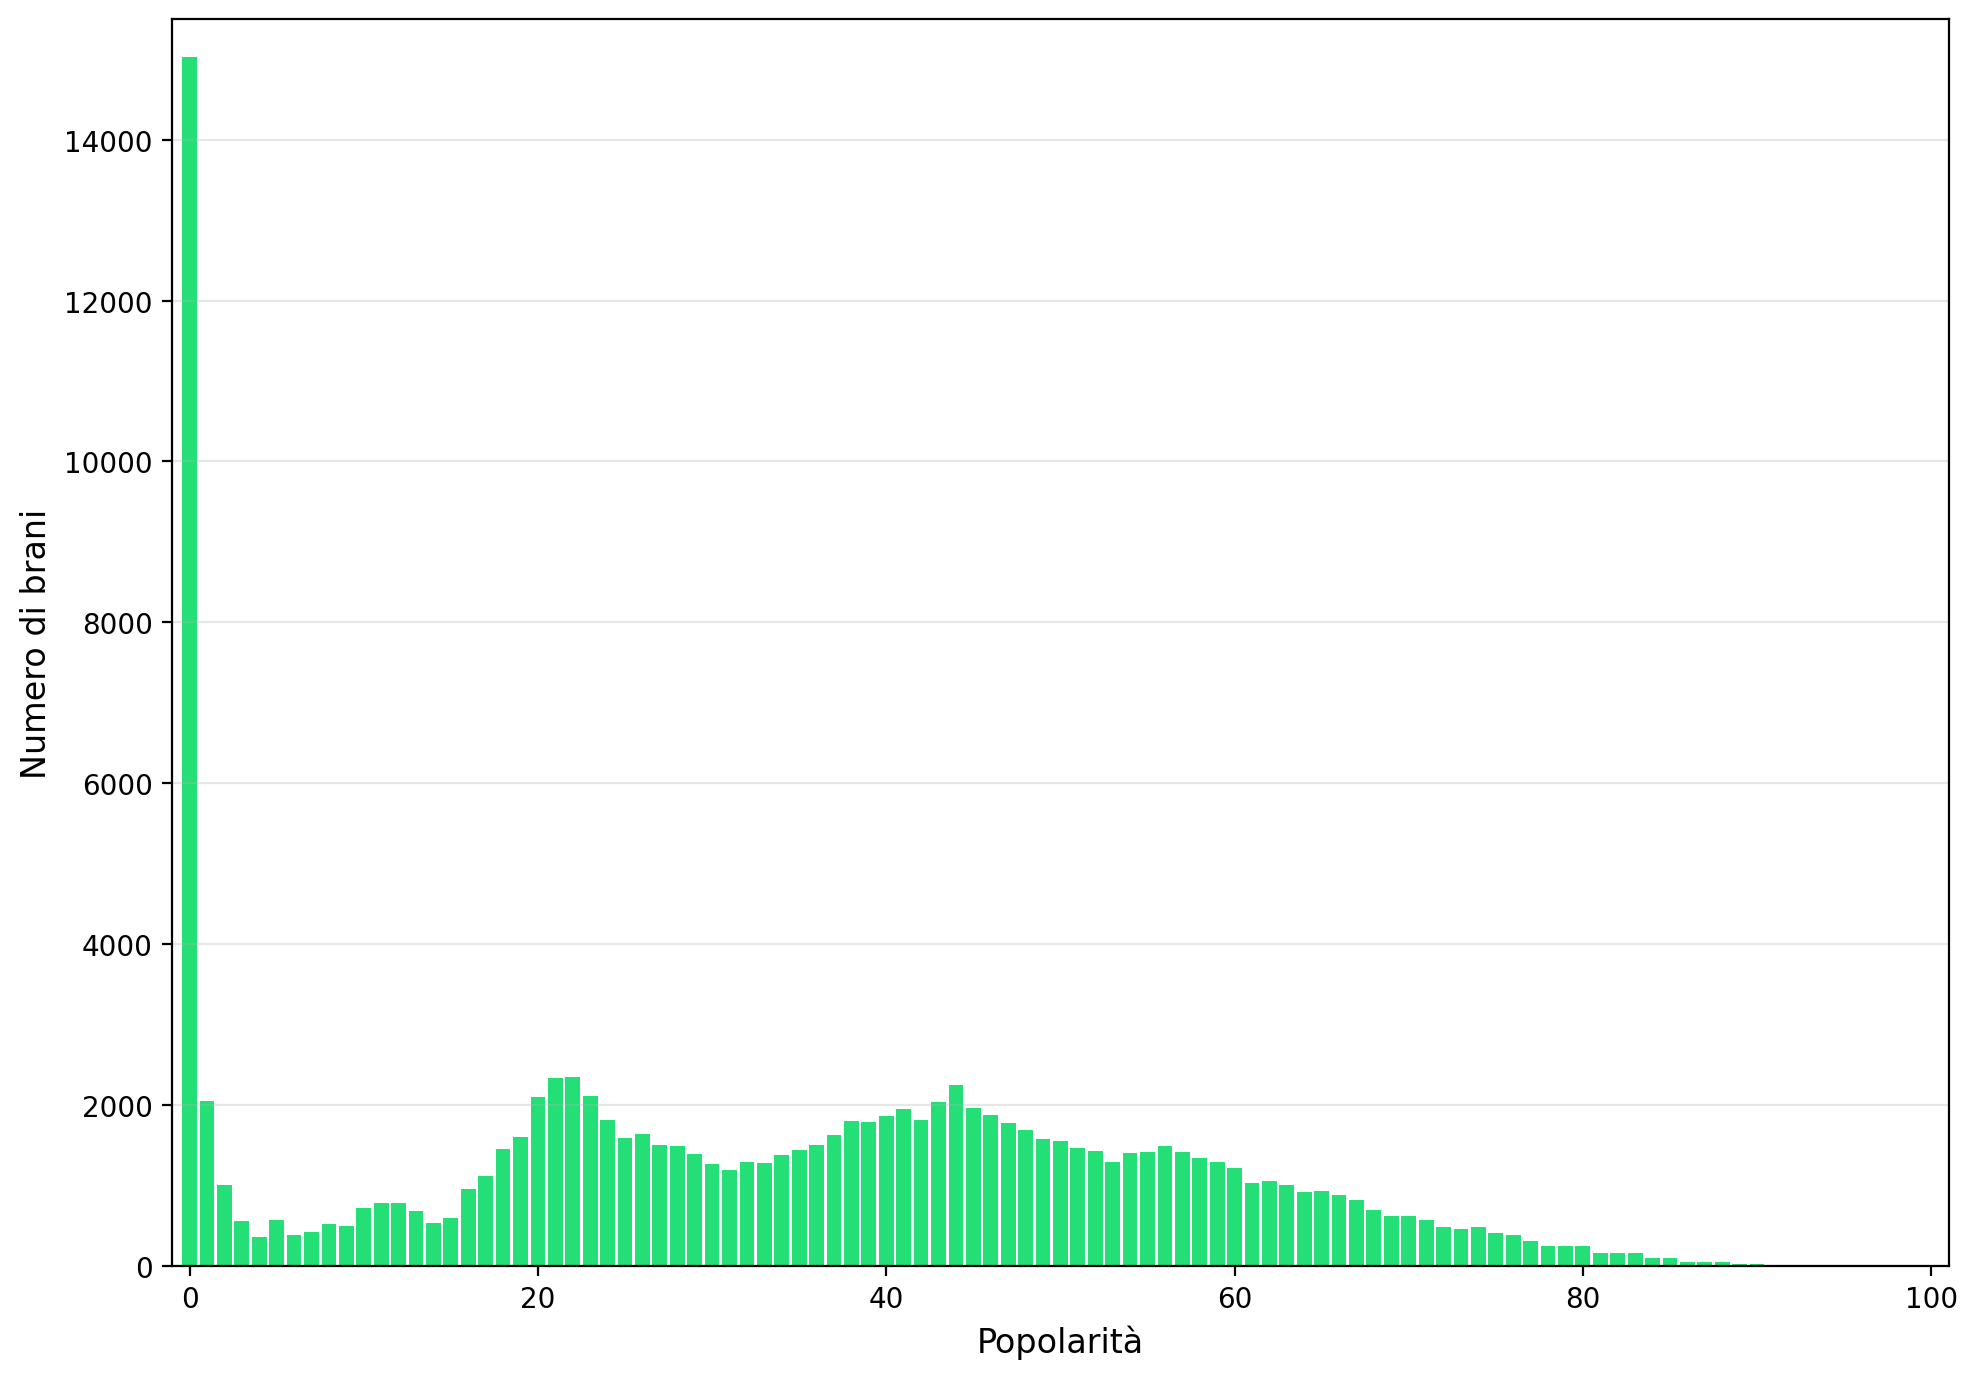

In [82]:
# n tracce per popolarità

popularity_count = df['popularity'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 7))

# Bar plot
ax.bar(popularity_count.index, popularity_count.values, color=spotifygreen, width=0.85)

ax.set_title('', fontsize=14)
ax.set_xlabel('Popolarità', fontsize=12)
ax.set_ylabel('Numero di brani', fontsize=12)

ax.set_xlim(-1,101)
ax.set_ylim(0,15500)

ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()

plt.show()
